In [1]:
from houseofreps import *
import numpy as np
import matplotlib.pyplot as plt
import csv 
import os
import pandas
from typing import List, Dict, Tuple
import scipy.stats as stats

# Representation per citizen of each state

In [2]:
def save_fig(fname: str):
    if not os.path.isdir("figures"):
        os.makedirs('figures')
    s = os.path.join("figures/",fname)
    plt.savefig(s)

    print("Saved figure to: %s" % s)

In [3]:
def write_csv_residents_per_rep(fname: str, residents_per_rep: Dict[str, Dict[str, float]]):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields
        header = ['year', 'state', 'residents per rep']
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for year, d2 in residents_per_rep.items():
            for state, rpr in d2.items():
                rows.append([year, state, "%.8f" % rpr])

        csvwriter.writerows(rows)

In [4]:
house = HouseOfReps()

residents_per_rep = {}
for year in Year:
    residents_per_rep[year.value] = {}

    house.reset_pops_assigned_to_true(year, PopType.APPORTIONMENT)

    for st, state in house.states.items():
        if st != St.DISTRICT_OF_COLUMBIA:
            residents_per_rep[year.value][st.name] = 1e6 * state.pop_true[year].apportionment / state.no_reps_true[year].voting
            # print(st.name," ",residents_per_rep)
    
    fair = 1e6 * house.get_total_us_pop_true_excluding_st(year,PopType.APPORTIONMENT,St.DISTRICT_OF_COLUMBIA) / 435.0
    residents_per_rep[year.value]['fair'] = fair

# Write
write_csv_residents_per_rep("analyze_data/residents_per_rep.csv",residents_per_rep)

## Plot

Saved figure to: figures/no_residents_per_rep_2020.png


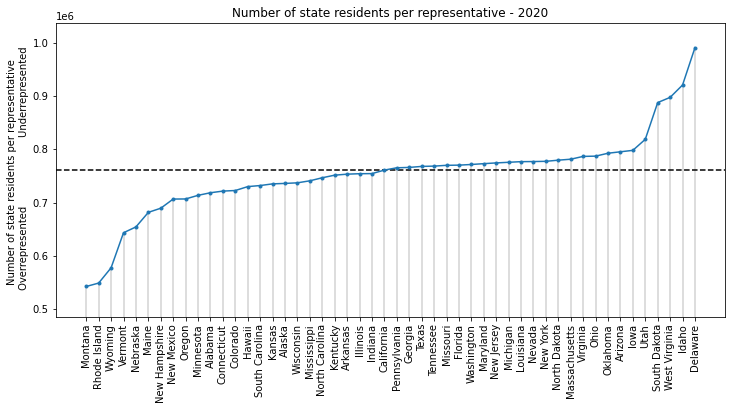

Saved figure to: figures/no_residents_per_rep_2010.png


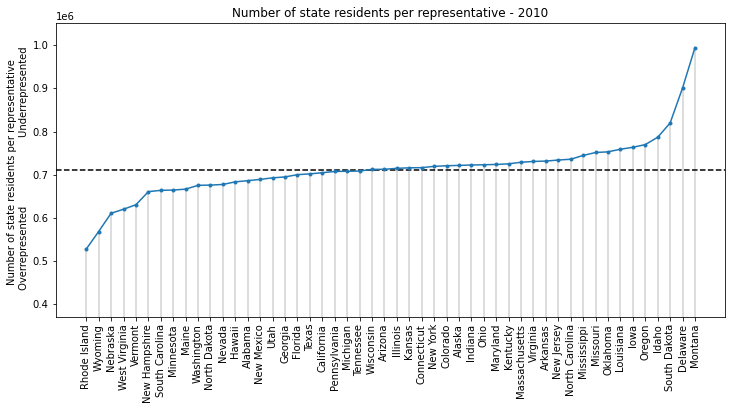

Saved figure to: figures/no_residents_per_rep_2000.png


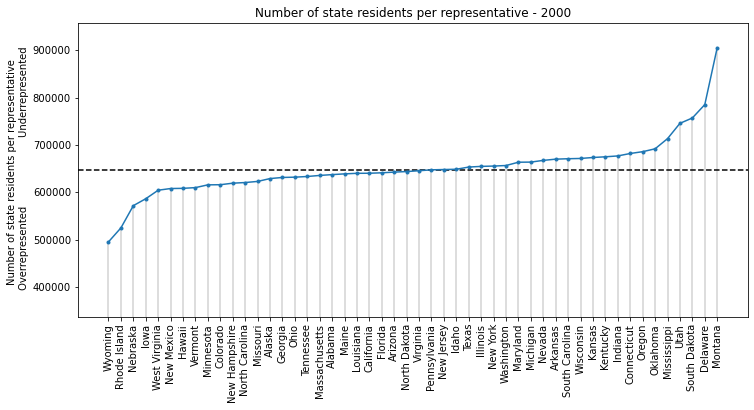

Saved figure to: figures/no_residents_per_rep_1990.png


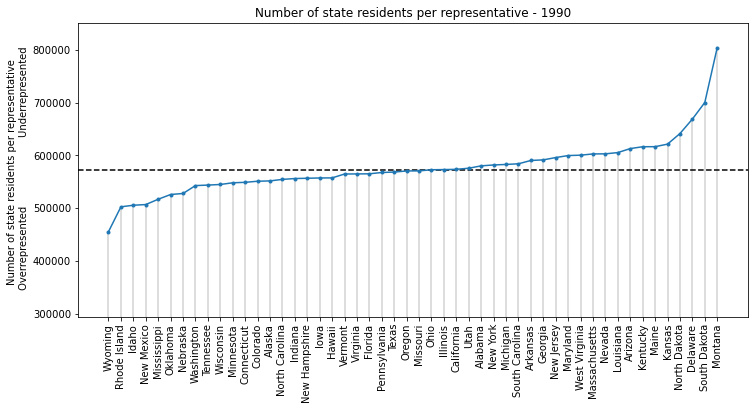

Saved figure to: figures/no_residents_per_rep_1980.png


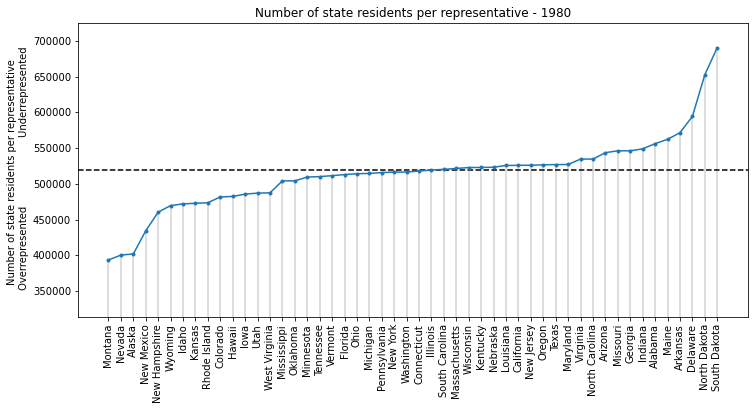

Saved figure to: figures/no_residents_per_rep_1970.png


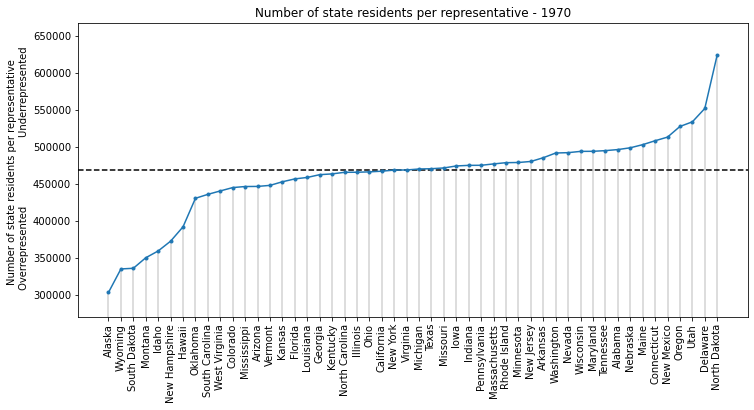

Saved figure to: figures/no_residents_per_rep_1960.png


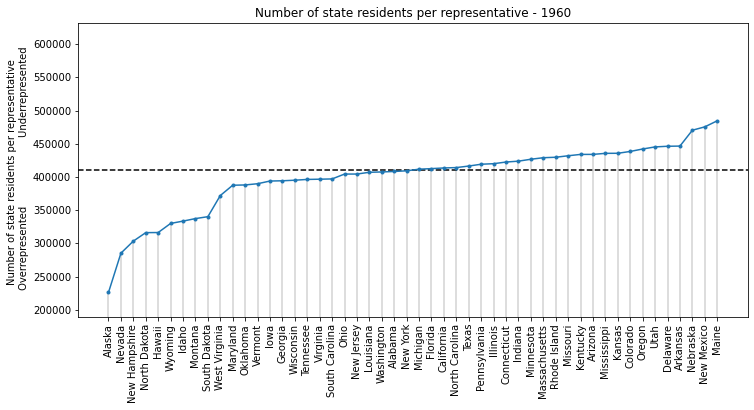

In [5]:
df = pd.read_csv('analyze_data/residents_per_rep.csv')

for year in Year:
    df_year = df[df['year'] == int(year.value)]
    fair = float(df_year[df_year['state'] == 'fair']['residents per rep'])
    df_year = df_year[df_year['state'] != 'fair']

    df_year = df_year.sort_values(by=['residents per rep'])

    xticks = list(df_year['state'])
    y = list(df_year['residents per rep'])
    x = np.arange(0,len(xticks))

    min_delta = fair - min(y)
    max_delta = max(y) - fair
    delta = 1.2*max(min_delta, max_delta)

    plt.figure(figsize=(12,6))
    plt.axhline(fair,linestyle='dashed',color='black')
    plt.xticks(x, xticks, rotation=90)
    plt.plot(x, y, '.-')
    plt.vlines(x, [0], y, color='lightgray')
    plt.ylabel("Number of state residents per representative \n Overrepresented                      Underrepresented")
    plt.ylim(fair-delta,fair+delta)
    plt.title('Number of state residents per representative - %s' % year.value)

    plt.subplots_adjust(bottom=0.2)
    save_fig('no_residents_per_rep_%s.png' % year.value)

    plt.show()

## Plot over/under representation as a bump chart in time

In [123]:
def load_fracs_residents_per_rep() -> Dict[Year, Dict[St,float]]:
    df = pd.read_csv('analyze_data/residents_per_rep.csv')

    fracs = {}
    for year in Year:
        df_year = df[df['year'] == int(year.value)]
        fair = float(df_year[df_year['state'] == 'fair']['residents per rep'])
        df_year = df_year[df_year['state'] != 'fair']

        df_year['frac'] = df_year['residents per rep'] / fair
        df_year = df_year.sort_values(by=['frac'])

        fracs[year] = {}
        for st in St.allExceptDC():
            fracs[year][st] = float(df_year[df_year['state'] == st.name]['frac'])
    
    return fracs

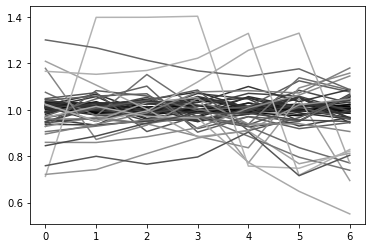

In [7]:
fracs = load_fracs_residents_per_rep()

plt_data = {}
for st in St.allExceptDC():
    x = np.arange(0,len(fracs))
    y = [fs[st] for fs in fracs.values()]

    # Color by the variance in the ranking to identify states that are consistently over/under represented
    mean = np.mean(y)
    std = np.std(y)

    plt_data[st] = (x,y,mean,std)

std_max = max([x[3] for x in plt_data.values()])
std_min = min([x[3] for x in plt_data.values()])

plt.figure()
for st, dat in plt_data.items():
    x, y, mean, std = dat
    col = 0.7 * (1 - pow(1 - (std-std_min) / (std_max - std_min),4))
    plt.plot(x, y, color=(col,col,col))

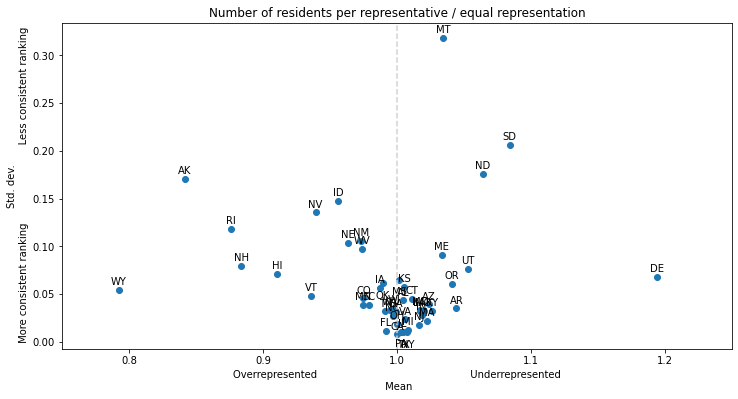

In [8]:
mean_dat = [x[2] for x in plt_data.values()]
std_dat = [x[3] for x in plt_data.values()]
labels = [x.value for x in plt_data.keys()]

plt.figure(figsize=(12,6))
plt.axvline(1,color='lightgray',linestyle='dashed')
plt.scatter(mean_dat, std_dat)
plt.xlabel('Overrepresented                                                 Underrepresented\n Mean')
plt.ylabel('Std. dev.\n More consistent ranking                         Less consistent ranking')
plt.title('Number of residents per representative / equal representation')
plt.xlim(0.75,1.25)

downs = ['TX','NY','PA','OK','MS']
for i, txt in enumerate(labels):
    if txt in downs:
        xytext=(0,-15)
    else:
        xytext=(0,5)
    plt.annotate(
        txt, 
        (mean_dat[i], std_dat[i]),
        textcoords="offset points", # how to position the text
        xytext=xytext, # distance from text to points (x,y)
        ha='center'
        ) # horizontal alignment can be left, right or center

In [ ]:
# Delaware is consistently underrepresented
# Wyoming in consistently overrepresented
# Montana has the largest fluctuations in the rankings
# Not political; on the overrepresented side, there is Wyoming (dominantly republican), but also New Hampshire, Hawaii, Vermont which are all dominantly democrat
# On the underrepresented side there is Delaware (democrat), but also Arkansas, South Dakota and Utah (republican)

## Plot with population

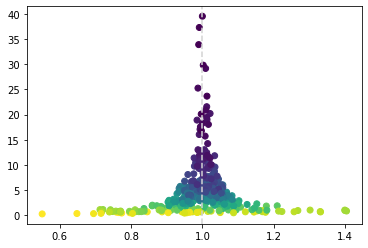

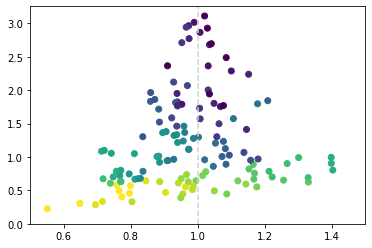

In [157]:
fracs = load_fracs_residents_per_rep()

states = load_states(list(St))
pops = {}
for year in Year:
    pops[year] = {}
    for st,state in states.items():
        pops[year][st] = state.pop_true[year].apportionment

x = []
y = []
cols = []
for year in Year:
    sts_year_ordered_by_pop = [(st,pop) for st,pop in pops[year].items()]
    sts_year_ordered_by_pop.sort(key = lambda x: -x[1])
    sts_year_ordered_by_pop = [s0[0] for s0 in sts_year_ordered_by_pop]

    for i,st in enumerate(St.allExceptDC()):
        x.append(fracs[year][st])
        y.append(pops[year][st])

        # Color indicates in ranking in population for this year
        cols.append(sts_year_ordered_by_pop.index(st))

plt.figure()
plt.scatter(x,y,c=cols)
plt.axvline(1,color='lightgray',linestyle='dashed')

plt.figure()
lim = 30
xplt = [x0 for i,x0 in enumerate(x) if cols[i] > lim]
yplt = [y0 for i,y0 in enumerate(y) if cols[i] > lim]
colsplt = [c0 for i,c0 in enumerate(cols) if cols[i] > lim]
plt.scatter(xplt,yplt,c=colsplt)
plt.ylim(0,)
plt.xlim(0.5,1.5)
plt.axvline(1,color='lightgray',linestyle='dashed')


In [ ]:
# This explains: higher population states (top) are less over/underrepresented
# Lower population states are more likely to be over-underrepresented
# But: why are some states like Delaware consistently underrepresented, and why are some like Wyoming consistently overrepresented?
# Look at left-right movement
# As states increase in population ranking, they move left (overrepresented) -> right (underrepresented), but then wrap around at a cutoff

### Rank populations

In [158]:
def load_state_pop_rankings():
    states = load_states(list(St))
    rankings = {}
    for year in Year:
        rankings[year] = []
        for st,state in states.items():
            if st == St.DISTRICT_OF_COLUMBIA:
                continue
            pop = state.pop_true[year].apportionment
            rankings[year].append((pop,st))

        rankings[year].sort(key = lambda x: -x[0])

    return rankings

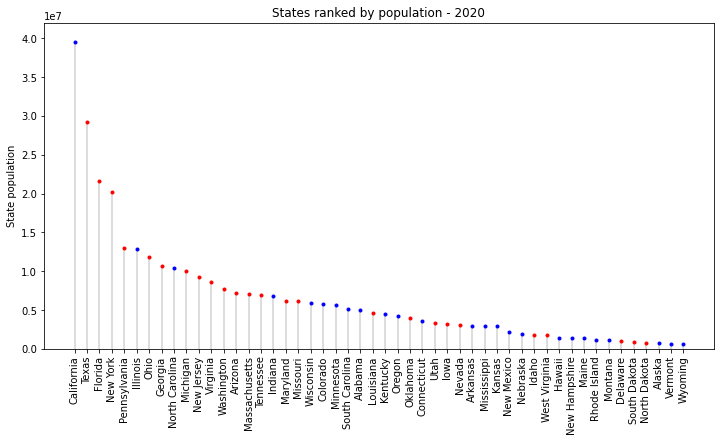

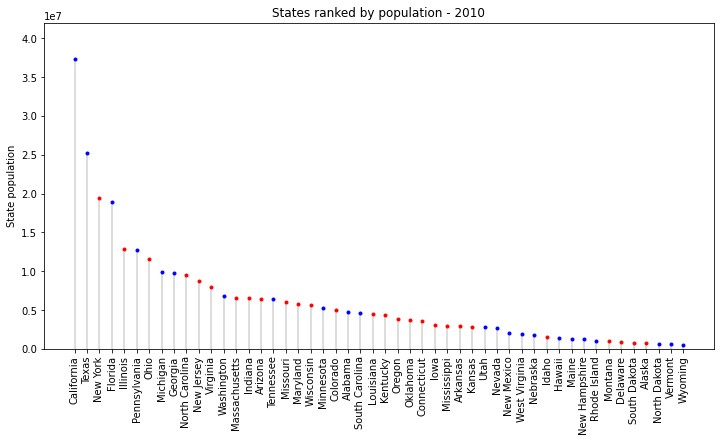

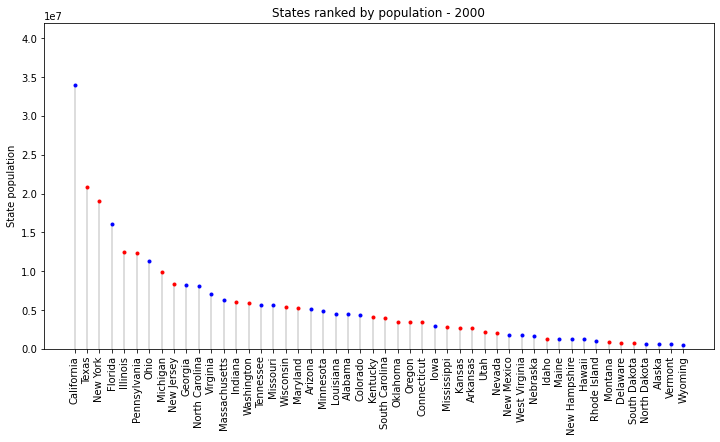

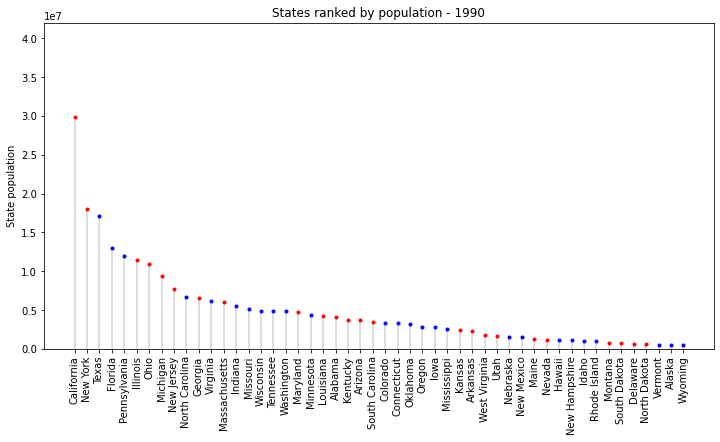

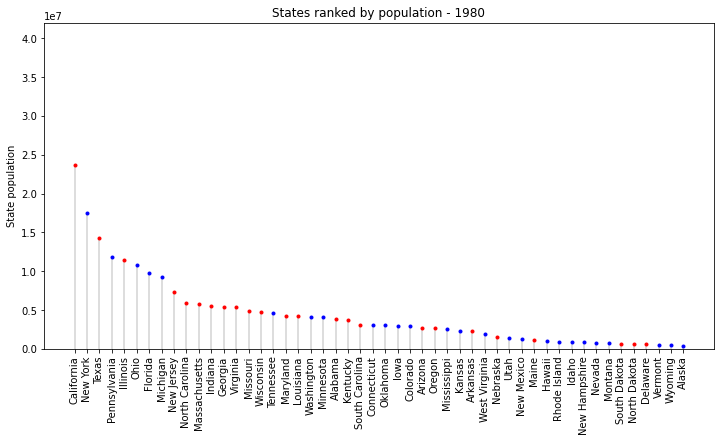

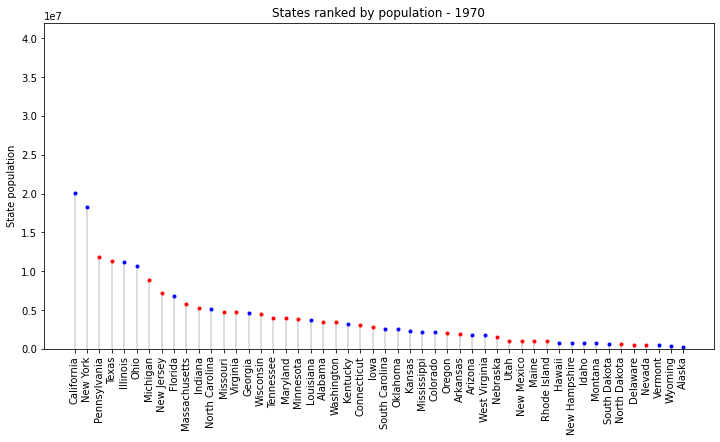

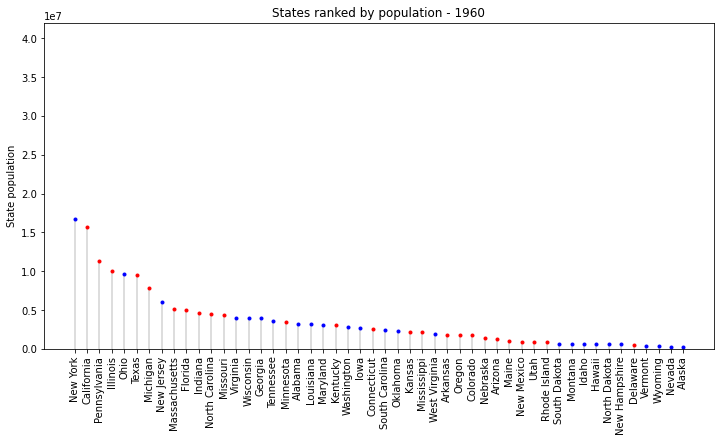

In [159]:
rankings = load_state_pop_rankings()

# st_best = [St.WYOMING,St.NEW_HAMPSHIRE,St.RHODE_ISLAND,St.MINNESOTA,St.HAWAII,St.ALASKA,St.COLORADO,St.FLORIDA,St.WEST_VIRGINIA,St.NEW_MEXICO]
# st_worst = [St.DELAWARE,St.ARKANSAS,St.MASSACHUSETTS,St.OREGON,St.NEW_JERSEY,St.SOUTH_DAKOTA,St.KENTUCKY,St.UTAH,St.NORTH_DAKOTA,St.MARYLAND]

st_best_name = {}
st_worst_name = {}
for year in Year:
    st_best_name[year] = []
    st_worst_name[year] = []
    for st in fracs[year].keys():
        if fracs[year][st] < 1:
            st_best_name[year].append(st.name)
        else:
            st_worst_name[year].append(st.name)

for year in Year:
    xticks = [p[1].name for p in rankings[year]]
    x = np.arange(0,len(xticks))
    y = [1e6*p[0] for p in rankings[year]]
    
    xb = [x0 for i,x0 in enumerate(x) if xticks[i] in st_best_name[year]]
    yb = [y0 for i,y0 in enumerate(y) if xticks[i] in st_best_name[year]]
    xr = [x0 for i,x0 in enumerate(x) if xticks[i] in st_worst_name[year]]
    yr = [y0 for i,y0 in enumerate(y) if xticks[i] in st_worst_name[year]]

    plt.figure(figsize=(12,6))
    plt.xticks(x, xticks, rotation=90)
    plt.plot(xb,yb,'.',color='b')
    plt.plot(xr,yr,'.',color='r')
    plt.ylim(0,42e6)
    plt.vlines(x, [0], y, color='lightgray')
    plt.title("States ranked by population - %s" % year.value)
    plt.ylabel("State population")

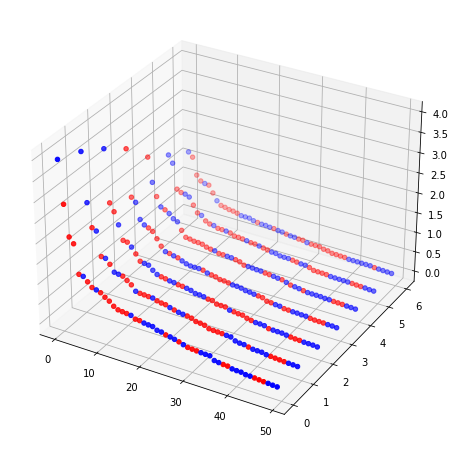

In [160]:
xallb = []
yallb = []
zallb = []
xallr = []
yallr = []
zallr = []
for iyear,year in enumerate(Year):
    xticks = [p[1].name for p in rankings[year]]
    x = np.arange(0,len(xticks))
    y = [1e6*p[0] for p in rankings[year]]
    
    xb = [x0 for i,x0 in enumerate(x) if xticks[i] in st_best_name[year]]
    yb = [y0 for i,y0 in enumerate(y) if xticks[i] in st_best_name[year]]
    xr = [x0 for i,x0 in enumerate(x) if xticks[i] in st_worst_name[year]]
    yr = [y0 for i,y0 in enumerate(y) if xticks[i] in st_worst_name[year]]
    
    xallb += xb
    yallb += yb
    zallb += len(xb) * [iyear]

    xallr += xr
    yallr += yr
    zallr += len(xr) * [iyear]

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(xallb,zallb,yallb,color='b')
ax.scatter(xallr,zallr,yallr,color='r')

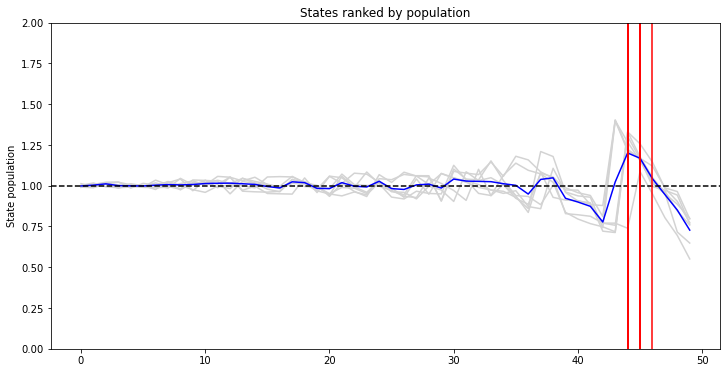

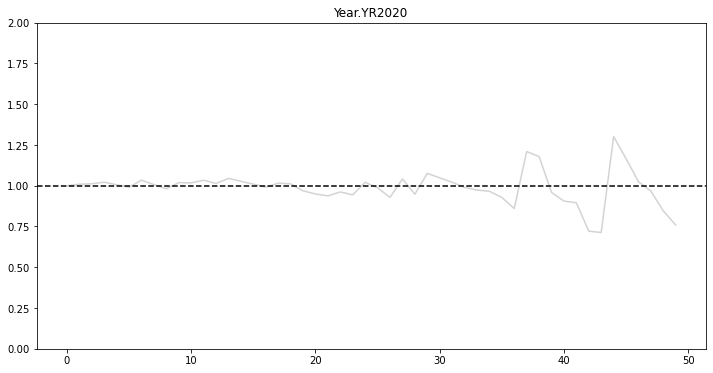

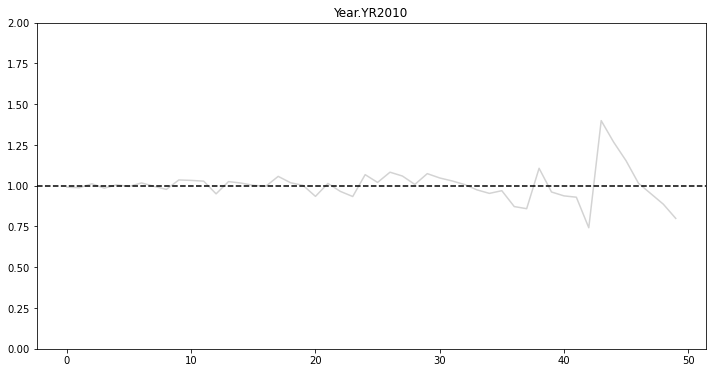

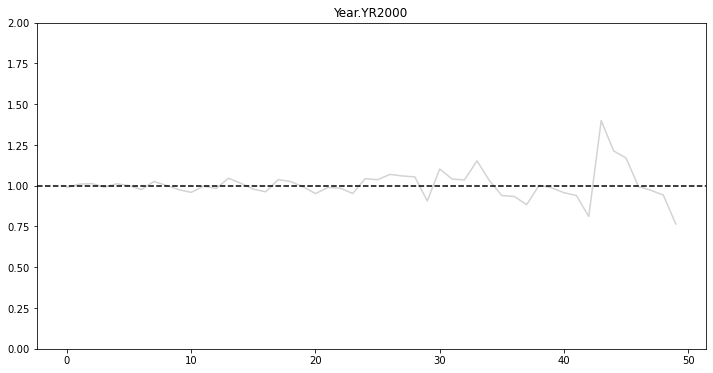

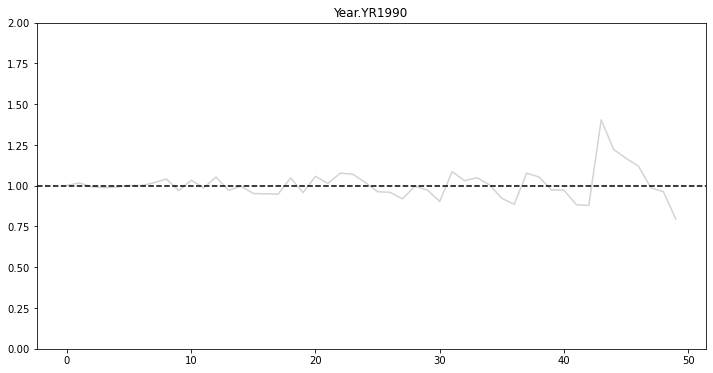

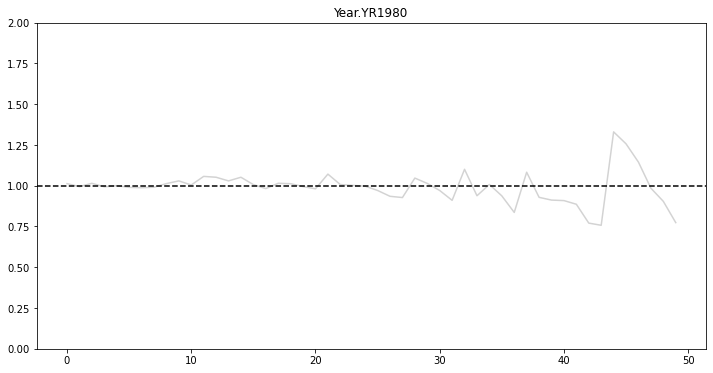

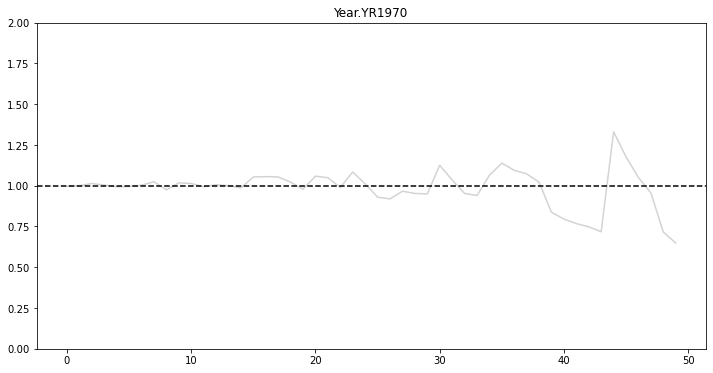

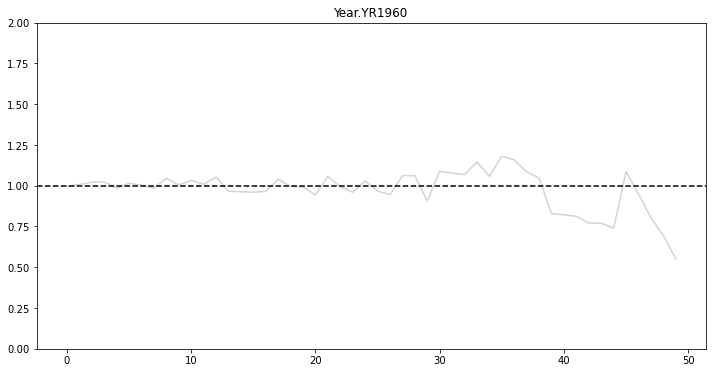

In [163]:
plt.figure(figsize=(12,6))
rankings_wo_pops = {}
for year in Year:
    rankings_wo_pops[year] = [x[1] for x in rankings[year]]

ys = []
for year in Year:
    x = np.arange(0,len(xticks))
    y = [fracs[year][st] for st in rankings_wo_pops[year]]
    ys.append(y)

    plt.plot(x,y,'-',color='lightgray')

y = np.mean(np.array(ys),axis=0)
plt.plot(x,y,'-',color='blue')

plt.axhline(1,color='black',linestyle='dashed')
plt.ylim(0,2)
plt.title("States ranked by population")
plt.ylabel("State population")

st = St.DELAWARE
st_ranks = [vals.index(st) for vals in rankings_wo_pops.values()]
for st_rank in st_ranks:
    plt.axvline(st_rank,color='red')

for year in Year:
    x = np.arange(0,len(xticks))
    y = [fracs[year][st] for st in rankings_wo_pops[year]]
    
    plt.figure(figsize=(12,6))
    plt.title(year)
    plt.plot(x,y,'-',color='lightgray')
    plt.axhline(1,color='black',linestyle='dashed')
    plt.ylim(0,2)

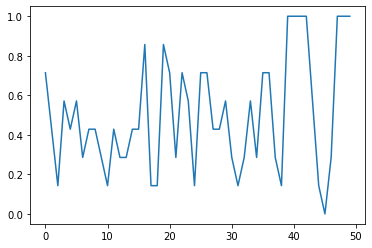

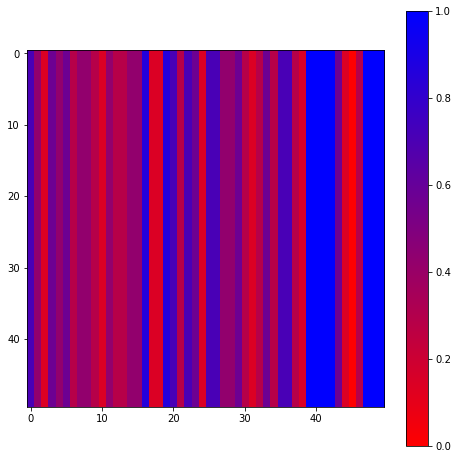

In [13]:
pos_cols = []
for i in range(0,50):
    ave = 0
    for year in Year:
        st_name = rankings[year][i][1].name
        if st_name in st_best_name[year]:
            ave += 1

    ave = float(ave) / len(Year)
    pos_cols.append(ave)

plt.plot(pos_cols)

vals = np.zeros((50,50))
for i in range(0,50):
    vals[i] = pos_cols

import matplotlib.colors as mcol
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
plt.figure(figsize=(8,8))
plt.imshow(vals,cmap=cm1)
plt.colorbar()
plt.show()


### Fit exponential dist

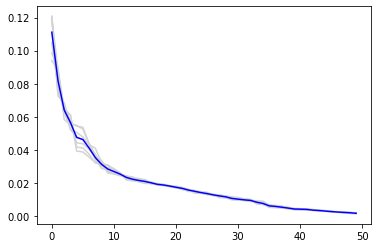

In [25]:
datas = []

house = HouseOfReps()
for year in Year: # [y for y in Year if y != Year.YR1980]:
    tot = house.get_total_us_pop_true_excluding_st(year, PopType.APPORTIONMENT, St.DISTRICT_OF_COLUMBIA)
    pops = [state.pop_true[year].apportionment for st,state in house.states.items() if st != St.DISTRICT_OF_COLUMBIA]
    pops.sort(key = lambda x: -x)
    data = list(np.array(pops)/tot)

    datas.append(data)

    plt.plot(data,color='lightgray')

mean = np.mean(np.array(datas), axis=0)
plt.plot(mean,color='b')

b c =  [ 0.25727819 -0.83932743]


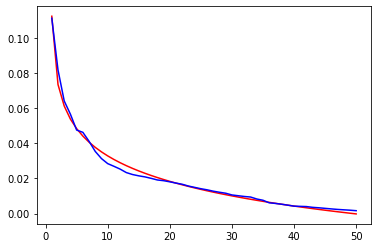

In [165]:
from scipy.optimize import curve_fit

xfit = np.arange(1,51)

def func_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

def func_log(x, a, b, c):
    return a - b * np.log(x + c)

def func_log2(x, b, c):
    return 1 - b * np.log(x + c)

def func_log_normed(x, a, b, c):
    return func_log(x,a, b,c) / sum([ func_log(y,a,b,c) for y in xfit ])

def func_log2_normed(x, b, c):
    return func_log2(x,b,c) / sum([ func_log2(y,b,c) for y in xfit ])

def func_gen_log(x, a, b, c, d):
    return a - b / (1 + np.exp(- c * (x - d)))

popt, pcov = curve_fit(func_log2_normed, xfit, mean, p0=[0.25, -0.8])
print("b c = ",popt)

fig, ax = plt.subplots(1, 1)
ax.plot(xfit, func_log2_normed(xfit, popt[0], popt[1]), 'r-')
plt.plot(xfit,mean,color='b')

## Comparisons

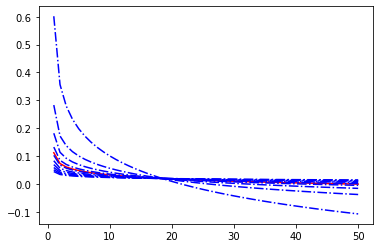

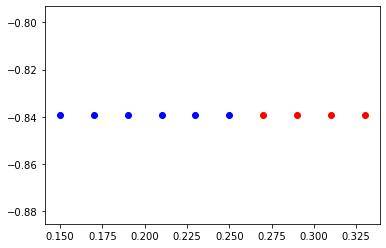

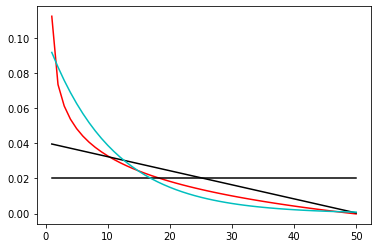

In [173]:
comparisons = {}
comparisons['true'] = func_log2_normed(xfit, popt[0], popt[1])
comparisons['true'] = [max(x,0) for x in comparisons['true']]

fig, ax = plt.subplots(1, 1)
ax.plot(xfit, func_log2_normed(xfit, popt[0], popt[1]), 'r-')
bs = np.arange(0.15,0.35,0.02)
for b in bs:
    ax.plot(xfit, func_log2_normed(xfit, b, popt[1]), 'b-.')

pos = []
neg = []
for b in bs:
    y = func_log2_normed(xfit, b, popt[1])
    if min(y) > 0:
        pos.append((b,popt[1]))
    else:
        neg.append((b,popt[1]))

for b,c in pos:
    y = func_log2_normed(xfit, b, c)
    comparisons["b%.4f_c%.4f" % (b,c)] = y

plt.figure()
plt.scatter([t[0] for t in pos],[t[1] for t in pos],color='b')
plt.scatter([t[0] for t in neg],[t[1] for t in neg],color='r')

fig, ax = plt.subplots(1, 1)
ax.plot(xfit, func_log2_normed(xfit, popt[0], popt[1]), 'r-')

lin = len(xfit) * [1.0 / len(xfit)]
comparisons["const"] = lin
plt.plot(xfit,lin,color='k')

a = 0.0008
lin = - a * xfit
s = np.sum(lin)
lin += (1 - s) / len(xfit)
assert min(lin) > 0
comparisons["lin"] = lin
plt.plot(xfit,lin,color='k')

a = 1.1
n = 50
xmin = (a-1) / (pow(a,n) - 1)
ys = [ pow(a,i) * xmin for i in reversed(range(0,n)) ]
comparisons["ys_%.4f" % a] = ys
plt.plot(xfit,ys,color='c')

In [168]:
comparisons.keys()

dict_keys(['true', 'b0.2000_c-0.8393', 'b0.2200_c-0.8393', 'b0.2400_c-0.8393', 'const', 'lin', 'ys_1.1000'])

In [174]:
house = HouseOfReps()

def sample_and_assign_house_seats(samples: List[float]) -> List[Tuple[float,float]]:
    # Assign to states
    # No need to scale by overall factor for population - only relative populations matter
    for i,st in enumerate(St.allExceptDC()):
        house.states[st].pop_assigned = samples[i]

    # Calculate house seats
    house.assign_house_seats_priority()

    # Calculate assignment fraction
    fair = float(house.get_total_us_pop_assigned_excluding_st(St.DISTRICT_OF_COLUMBIA)) / 435.0
    fracs_and_pops = []
    for st in St.allExceptDC():
        res_per_rep = float(house.states[st].pop_assigned) / float(house.states[st].no_reps_assigned.voting)
        frac = float(res_per_rep) / float(fair)
        fracs_and_pops.append((frac, house.states[st].pop_assigned))
    
    # Sort
    fracs_and_pops.sort(key = lambda x: -x[1])
    
    fracs = [x[0] for x in fracs_and_pops]
    return fracs

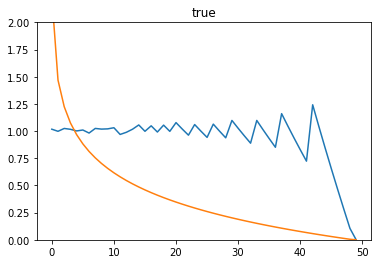

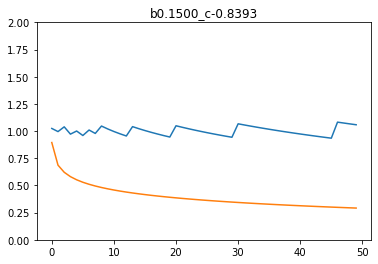

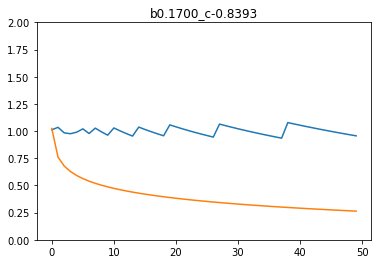

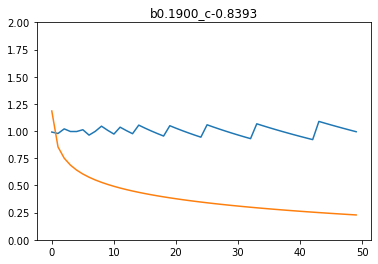

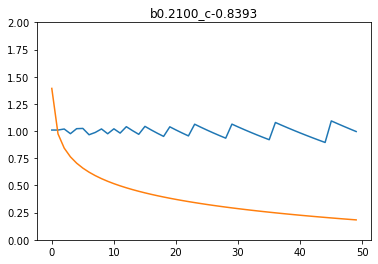

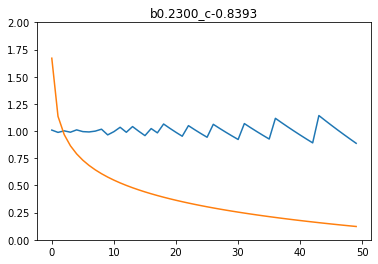

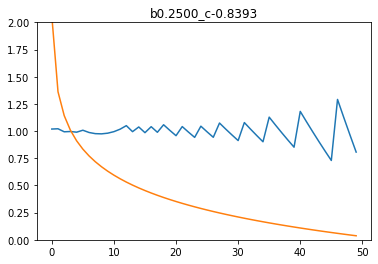

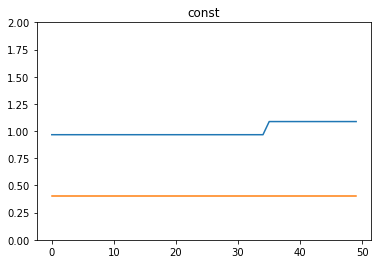

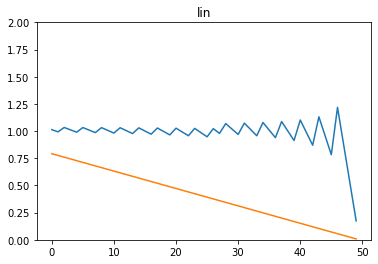

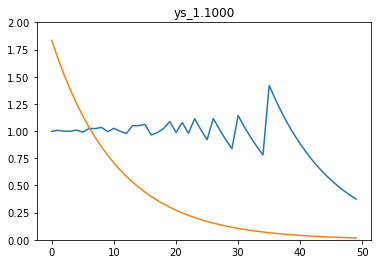

In [175]:
for name, samples in comparisons.items():
    fracs = sample_and_assign_house_seats(samples)

    plt.figure()
    plt.title(name)
    plt.plot(fracs)
    plt.ylim(0,2)
    plt.plot(20*np.array(samples))

    #if name == 'true':
    #    break

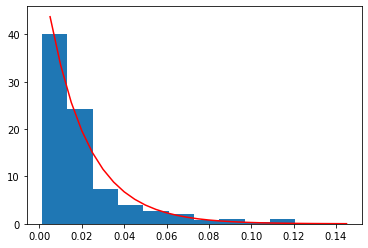

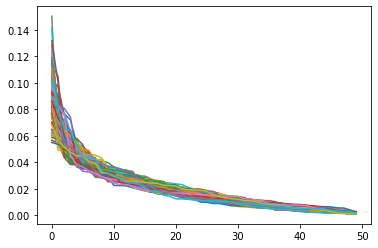

In [150]:
fig, ax = plt.subplots(1, 1)

data_fit = np.array(datas).flatten()
plt.hist(data_fit,density=True)

loc_expon, scale_expon = stats.expon.fit(data_fit, loc=0, scale=1)

d = 0.005
x = np.arange(d,0.15,d)
ax.plot(x, stats.expon.pdf(x, loc_expon, scale_expon), 'r-')

plt.figure()
for i in range(0,100):
    samples = list(stats.expon.rvs(loc_expon, scale_expon, size=50))
    samples.sort(key = lambda x: -x)
    samples /= np.sum(samples)

    plt.plot(samples)

In [74]:
data = []

house = HouseOfReps()
for year in [y for y in Year if y != Year.YR1980]:
    tot = house.get_total_us_pop_true_excluding_st(year, PopType.APPORTIONMENT, St.DISTRICT_OF_COLUMBIA)
    data += [state.pop_true[year].apportionment / tot for st,state in house.states.items() if st != St.Di]

loc_expon, scale_expon = stats.expon.fit(data, loc=0, scale=1)
c_weibull, loc_weibull, scale_weibull = stats.weibull_min.fit(data, 1, loc=0, scale=1)
c_burr, d_burr, loc_burr, scale_burr = stats.burr.fit(data, 1, 1, loc=0, scale=1)
c_pareto, loc_pareto, scale_pareto = stats.pareto.fit(data, 1, loc=0, scale=1)
c_fisk, loc_fisk, scale_fisk = stats.fisk.fit(data, 1, loc=0, scale=1)
c_frechet, loc_frechet, scale_frechet = stats.weibull_min.fit(data,1,loc=0,scale=1)

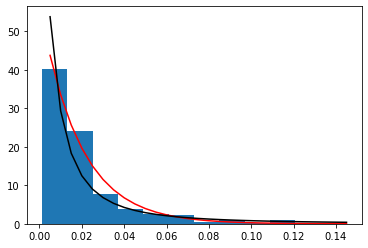

In [75]:
fig, ax = plt.subplots(1, 1)
plt.hist(data, density=True)

d = 0.005
x = np.arange(d,0.15,d)
ax.plot(x, stats.expon.pdf(x, loc_expon, scale_expon), 'r-')
# ax.plot(x, stats.weibull_min.pdf(x, c_weibull, loc_weibull, scale_weibull), 'c-')
# ax.plot(x, stats.burr.pdf(x, c_burr, d_burr, loc_burr, scale_burr), 'c-')
ax.plot(x, stats.pareto.pdf(x, c_pareto, loc_pareto, scale_pareto), 'k-')
# ax.plot(x, stats.fisk.pdf(x, c_fisk, loc_fisk, scale_fisk), 'c-')
# ax.plot(x, stats.weibull_min.pdf(x, c_frechet, loc_frechet, scale_frechet), 'c-')

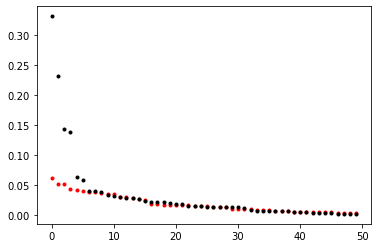

In [76]:
# Sample populations
samples = list(stats.expon.rvs(loc_expon, scale_expon, size=50))
samples.sort(key = lambda x: -x)

plt.figure()
plt.plot(samples,'.',color='r')

samples = list(stats.pareto.rvs(c_pareto, loc_pareto, scale_pareto, size=50))
samples.sort(key = lambda x: -x)

plt.plot(samples,'.',color='k')

In [77]:
def sample_pareto():
    return list(stats.pareto.rvs(c_pareto, loc_pareto, scale_pareto, size=50))

def sample_expon():
    return list(stats.expon.rvs(loc_expon, scale_expon, size=50))

In [78]:
house = HouseOfReps()

def sample_and_assign_house_seats(samples: List[float]) -> Dict[St,Tuple[float,float]]:
    # Assign to states
    # No need to scale by overall factor for population - only relative populations matter
    for i,st in enumerate(St.allExceptDC()):
        house.states[st].pop_assigned = samples[i]

    # Calculate house seats
    house.assign_house_seats_priority()

    # Calculate assignment fraction
    fair = float(house.get_total_us_pop_assigned_excluding_st(St.DISTRICT_OF_COLUMBIA)) / 435.0
    fracs_and_pops = {}
    for st in St.allExceptDC():
        res_per_rep = float(house.states[st].pop_assigned) / float(house.states[st].no_reps_assigned.voting)
        frac = float(res_per_rep) / float(fair)
        fracs_and_pops[st] = (frac, house.states[st].pop_assigned)
    
    return fracs_and_pops

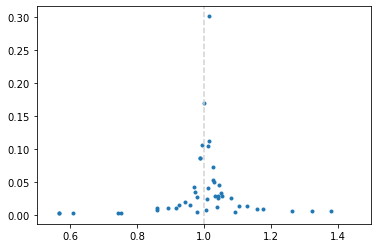

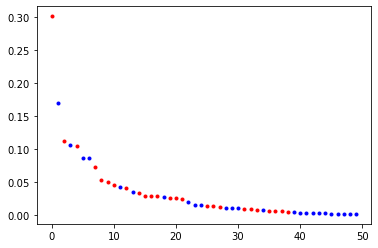

In [83]:
samples = sample_pareto()
fracs_and_pops = sample_and_assign_house_seats(samples)

# Sort
fracs_and_pops = [(st, dat[0], dat[1]) for st, dat in fracs_and_pops.items()]
fracs_and_pops.sort(key = lambda x: -x[2])

plt.figure()
x = [f[1] for f in fracs_and_pops]
y = [f[2] for f in fracs_and_pops]
plt.plot(x,y,'.')
plt.axvline(1,color='lightgray',linestyle='dashed')
plt.xlim(0.5,1.5)

x = np.arange(0,50)
y = [f[2] for f in fracs_and_pops]
xb = [x0 for i,x0 in enumerate(x) if fracs_and_pops[i][1] < 1]
yb = [y0 for i,y0 in enumerate(y) if fracs_and_pops[i][1] < 1]
xr = [x0 for i,x0 in enumerate(x) if fracs_and_pops[i][1] > 1]
yr = [y0 for i,y0 in enumerate(y) if fracs_and_pops[i][1] > 1]

plt.figure()
plt.plot(xb,yb,'.',color='b')
plt.plot(xr,yr,'.',color='r')

In [80]:
def reap_frac_over(fracs_and_pops):
    fracs_and_pops = [(st, dat[0], dat[1]) for st, dat in fracs_and_pops.items()]
    fracs_and_pops.sort(key = lambda x: -x[2])

    idxs_underrepresented = [i for i,dat in enumerate(fracs_and_pops) if dat[1] > 1]
    ret = np.zeros(50)
    ret[idxs_underrepresented] = 2

    return ret

In [81]:
methods = {
    "expon": sample_expon,
    "pareto": sample_pareto
    }

fracs_over = {}
for name, sample_method in methods.items():

    fracs_over[name] = np.zeros(50)
    no_samples = 5000
    for sample in range(0,no_samples):
        if sample % (no_samples / 10) == 0:
            print("%s %d / %d" % (name, sample, no_samples))

        samples = sample_method()
        fracs_and_pops = sample_and_assign_house_seats(samples)
        fracs_over[name] += reap_frac_over(fracs_and_pops)

    fracs_over[name] /= no_samples

expon 0 / 5000
expon 500 / 5000
expon 1000 / 5000
expon 1500 / 5000
expon 2000 / 5000
expon 2500 / 5000
expon 3000 / 5000
expon 3500 / 5000
expon 4000 / 5000
expon 4500 / 5000
pareto 0 / 5000
pareto 500 / 5000
pareto 1000 / 5000
pareto 1500 / 5000
pareto 2000 / 5000
pareto 2500 / 5000
pareto 3000 / 5000
pareto 3500 / 5000
pareto 4000 / 5000
pareto 4500 / 5000


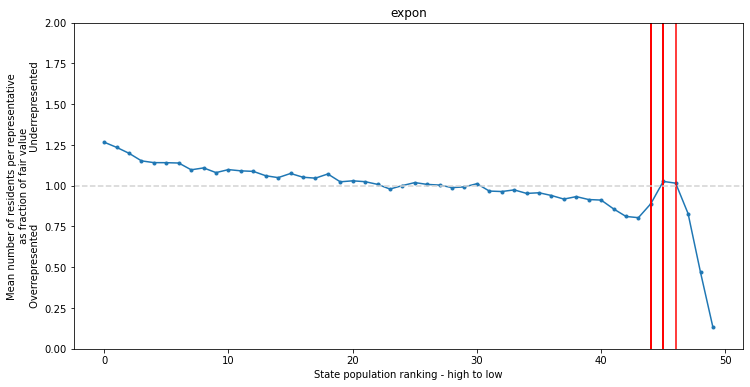

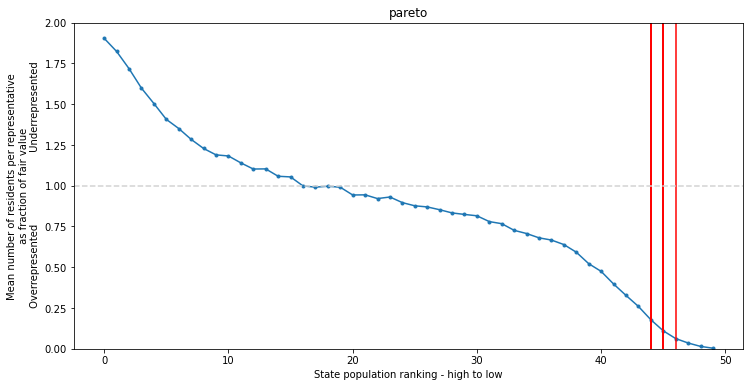

In [82]:
rankings = load_state_pop_rankings()
rankings = { d2: [x[1] for x in lst] for d2, lst in rankings.items() }
st = St.DELAWARE
st_ranks = [vals.index(st) for vals in rankings.values()]

for method_name, vals in fracs_over.items():
    plt.figure(figsize=(12,6))
    plt.plot(vals,'.-')
    plt.title(method_name)
    for st_rank in st_ranks:
        plt.axvline(st_rank,color='red')
    plt.ylim(0,2)
    plt.axhline(1,color='lightgray',linestyle='dashed')
    plt.xlabel("State population ranking - high to low")
    plt.ylabel("Mean number of residents per representative\n as fraction of fair value \n Overrepresented                       Underrepresented")

# Assign reps priorities

In [2]:
house = HouseOfReps()
house.reset_pops_assigned_to_true(Year.YR2000, PopType.APPORTIONMENT)
pris = house.assign_house_seats_priority(return_priorities_all=True)

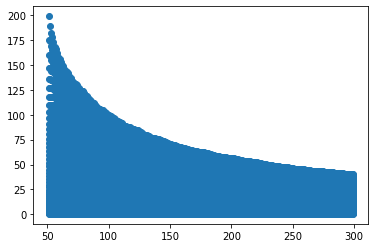

In [23]:
xs = []
ys = []
cs = []

steps = np.arange(51,300)
for step in steps:
    p = [x.priority for x in pris.priorities_all[step]]
    pcdf = []
    for i in range(0,len(p)):
        pcdf.append(sum(p[:i+1]))

    x = len(p) * [step]

    xs += x
    ys += pcdf

plt.scatter(xs,ys)

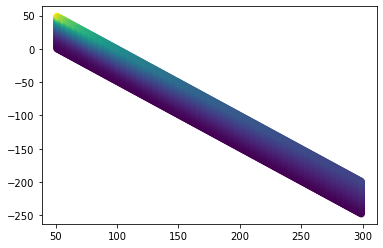

In [22]:
xs = []
ys = []
cs = []

steps = np.arange(51,300)
for step in steps:
    p = [x.priority for x in pris.priorities_all[step]]
    pcdf = []
    for i in range(0,len(p)):
        pcdf.append(sum(p[:i+1]))

    x = len(p) * [step]
    offset = step - steps[0]
    y = list(np.arange(0,len(p)) - offset)

    xs += x
    ys += y
    cs += pcdf

plt.scatter(xs,ys,c=cs)

# Calculate how number of reps changes when population is increased/decreased, for each state

In [3]:
def write_csv(fname: str, pops_shift_millions: List[float], no_reps_assigned: Dict[St,List[Tuple[float,int,int]]]):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields
        header = ['population shift (millions)']
        for st in no_reps_assigned.keys():
            header.append(st.value + " population (millions)")
            header.append(st.value + " no reps (voting)")
            header.append(st.value + " no reps (nonvoting)")
        
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for i in range(0,len(list(no_reps_assigned.values())[0])):
            row = ["%.8f" % pops_shift_millions[i]]
            for nra in no_reps_assigned.values():
                row.append("%.8f" % nra[i][0]) # population (millions)
                row.append(nra[i][1]) # no voting reps
                row.append(nra[i][2]) # no nonvoting reps
            rows.append(row)

        csvwriter.writerows(rows)

In [8]:
def calculate_no_reps_assigned(house: HouseOfReps, year: Year, pops_shift_millions: List[float]) -> Dict[St,List[Tuple[float,int,int]]]:
    no_reps_assigned = {}
    for st2 in St:
        no_reps_assigned[st2] = []

    for pop_shift_millions in pops_shift_millions:
        house.reset_pops_assigned_to_true(year, PopType.APPORTIONMENT)
        try:
            house.shift_pop_from_entire_us_to_state(
                st_to=st, 
                pop_add_millions=pop_shift_millions, 
                verbose=False
                )
        except:
            # Population of state would be negative
            print("Stopping early - removing: %f people is more than the number of people in the state" % pop_shift_millions)
            break

        house.assign_house_seats_priority()

        for st2 in St:
            pop = house.states[st2].pop_assigned
            n1 = house.states[st2].no_reps_assigned.voting
            n2 = house.states[st2].no_reps_assigned.nonvoting
            no_reps_assigned[st2].append((pop,n1,n2))
    
    return no_reps_assigned

In [9]:
house = HouseOfReps()

# Population to add to the state, detracted from the rest of the USA
pops_add_millions = list(0.005*np.arange(0,201))
pops_lost_millions = list(-0.005*np.arange(0,201))

for year in Year:

    # For exporting data
    dir_name_add = 'analyze_data/population_add_%s' % year.value
    dir_name_lose = 'analyze_data/population_lose_%s' % year.value
    if not os.path.isdir(dir_name_add):
        os.makedirs(dir_name_add)
    if not os.path.isdir(dir_name_lose):
        os.makedirs(dir_name_lose)
    
    for st in St:
        print("Calculating for year: %s state: %s" % (year.value, st.name))
        
        no_reps_assigned = calculate_no_reps_assigned(house, year, pops_add_millions)
        write_csv(os.path.join(dir_name_add, '%s.csv' % st.value), pops_add_millions, no_reps_assigned)

        no_reps_assigned = calculate_no_reps_assigned(house, year, pops_lost_millions)
        write_csv(os.path.join(dir_name_lose, '%s.csv' % st.value), pops_lost_millions, no_reps_assigned)

Calculating for year: 2020 state: California
Calculating for year: 2020 state: Texas
Calculating for year: 2020 state: Florida
Calculating for year: 2020 state: New York
Calculating for year: 2020 state: Pennsylvania
Calculating for year: 2020 state: Illinois
Calculating for year: 2020 state: Ohio
Calculating for year: 2020 state: Georgia
Calculating for year: 2020 state: North Carolina
Calculating for year: 2020 state: Michigan
Calculating for year: 2020 state: New Jersey
Calculating for year: 2020 state: Virginia
Calculating for year: 2020 state: Washington
Calculating for year: 2020 state: Arizona
Calculating for year: 2020 state: Massachusetts
Calculating for year: 2020 state: Tennessee
Calculating for year: 2020 state: Indiana
Calculating for year: 2020 state: Missouri
Calculating for year: 2020 state: Maryland
Calculating for year: 2020 state: Wisconsin
Calculating for year: 2020 state: Colorado
Calculating for year: 2020 state: Minnesota
Calculating for year: 2020 state: South C

# Min population shift to get an additional representative

In [12]:
def write_csv_rep(fname: str, header: List[str], min_pop_changes_for_next_rep):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields        
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for i in range(0,len(min_pop_changes_for_next_rep)):
            st, min_pop_change_for_next_rep, st_lost, pop_lost = min_pop_changes_for_next_rep[i]
            row = [
                st.name,
                "%.4f" % min_pop_change_for_next_rep,
                st_lost.name,
                "%.4f" % pop_lost
            ]
            rows.append(row)

        csvwriter.writerows(rows)

In [20]:
def calc_min_pop_changes_for_next_rep(year: Year, verbose: bool):
    min_pop_changes_for_next_rep = []
    for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
        # Import data
        fname = 'analyze_data/population_add_%s/%s.csv' % (year.value,st.value)
        df = pandas.read_csv(fname)
        
        pop_shifts_millions = df['population shift (millions)'].to_numpy()
        no_reps_voting = df['%s no reps (voting)' % st.value].to_numpy()

        ichange = -1
        for i in range(1,len(no_reps_voting)):
            if no_reps_voting[i] != no_reps_voting[0]:
                # Found it
                ichange = i
                break

        if ichange != -1:
            min_pop_change_for_next_rep = pop_shifts_millions[ichange]
        else:
            min_pop_change_for_next_rep = 10000
        
        # Who lost the rep?
        st_lost = None
        for st_2 in St:
            if st_2 == st:
                continue
            no_reps_2 = df['%s no reps (voting)' % st_2.value].to_numpy()
            if no_reps_2[0] != no_reps_2[ichange]:
                # This is the one
                if st_lost != None:
                    print("ERROR: 2 states lost a rep??? Something went wrong!")
                    assert False
                st_lost = st_2
        
        # Population lost in this state
        pop_lost = None
        if st_lost != None:
            pop_lost = df["%s population (millions)" % st_lost.value][0] - df["%s population (millions)" % st_lost.value][ichange]

        min_pop_changes_for_next_rep.append((st,min_pop_change_for_next_rep, st_lost, pop_lost))

    # Sort
    min_pop_changes_for_next_rep.sort(key = lambda x: x[1])
    if verbose:
        for x in min_pop_changes_for_next_rep:
            print("%s %s: min pop change for next rep (millions): %.4f state that lost the rep: %s pop lost: %s" % (year.value, x[0].value, x[1], x[2], x[3]))

    return min_pop_changes_for_next_rep

In [25]:
for year in Year:
    min_pop_changes_for_next_rep = calc_min_pop_changes_for_next_rep(year, verbose=False)

    header = ['state', 'min. population change for next rep', 'state that lost the rep', 'population this other state lost']
    write_csv_rep("analyze_data/one_more_rep_%s.csv" % year.value, header, min_pop_changes_for_next_rep)

In [34]:
_ = calc_min_pop_changes_for_next_rep(Year.YR2020, verbose=True)

2020 NY: min pop change for next rep (millions): 0.0050 state that lost the rep: St.MINNESOTA pop lost: 9.16300000000092e-05
2020 OH: min pop change for next rep (millions): 0.0150 state that lost the rep: St.MINNESOTA pop lost: 0.0002676499999996196
2020 ID: min pop change for next rep (millions): 0.0300 state that lost the rep: St.MINNESOTA pop lost: 0.0005191399999997515
2020 WV: min pop change for next rep (millions): 0.0750 state that lost the rep: St.MINNESOTA pop lost: 0.0012976599999996452
2020 AZ: min pop change for next rep (millions): 0.0800 state that lost the rep: St.MINNESOTA pop lost: 0.001407040000000137
2020 DE: min pop change for next rep (millions): 0.0900 state that lost the rep: St.MINNESOTA pop lost: 0.0015534099999996442
2020 VA: min pop change for next rep (millions): 0.1100 state that lost the rep: St.MINNESOTA pop lost: 0.00194362999999953
2020 UT: min pop change for next rep (millions): 0.1400 state that lost the rep: St.MINNESOTA pop lost: 0.0024332099999995

# Min population shift to lose a representative

In [29]:
def calc_min_pop_changes_for_losing_rep(year: Year, verbose: bool):
    min_pop_changes_for_losing_rep = []
    for st in St:
        # Import data
        fname = 'analyze_data/population_lose_%s/%s.csv' % (year.value,st.value)
        df = pandas.read_csv(fname)
        
        pop_shifts_millions = df['population shift (millions)'].to_numpy()
        no_reps_voting = df['%s no reps (voting)' % st.value].to_numpy()

        ichange = -1
        for i in range(1,len(no_reps_voting)):
            if no_reps_voting[i] != no_reps_voting[0]:
                # Found it
                ichange = i
                break

        if ichange == -1:
            continue
        min_pop_change_for_losing_rep = pop_shifts_millions[ichange]

        # Who gained the rep?
        st_gained = None
        for st_2 in St:
            if st_2 == st:
                continue
            no_reps_2 = df['%s no reps (voting)' % st_2.value].to_numpy()
            if no_reps_2[0] != no_reps_2[ichange]:
                # This is the one
                if st_gained != None:
                    print("ERROR: 2 states gaining a rep??? Something went wrong!")
                    assert False
                st_gained = st_2
        
        # Population gained in this state
        pop_gained = None
        if st_gained != None:
            pop_gained = df["%s population (millions)" % st_gained.value][ichange] - df["%s population (millions)" % st_gained.value][0]

        min_pop_changes_for_losing_rep.append((st, min_pop_change_for_losing_rep, st_gained, pop_gained))

    # Sort
    min_pop_changes_for_losing_rep.sort(key = lambda x: -x[1])
    if verbose:
        for x in min_pop_changes_for_losing_rep:
            print("%s: min pop change for losing rep (millions): %.4f state that gained the rep: %s pop gained: %s" % (x[0], x[1], x[2], x[3]))

    return min_pop_changes_for_losing_rep

In [31]:
for year in Year:
    min_pop_changes_for_losing_rep = calc_min_pop_changes_for_losing_rep(year, verbose=False)

    header = ['state', 'min. population change for losing rep', 'state that gained the rep', 'population this other state gained']
    write_csv_rep("analyze_data/one_less_rep_%s.csv" % year.value, header, min_pop_changes_for_losing_rep)

In [35]:
_ = calc_min_pop_changes_for_losing_rep(Year.YR2020, verbose=True)

St.MINNESOTA: min pop change for losing rep (millions): -0.0050 state that gained the rep: St.NEW_YORK pop gained: 0.00030996999999999275
St.MONTANA: min pop change for losing rep (millions): -0.0100 state that gained the rep: St.NEW_YORK pop gained: 0.0006112799999975493
St.RHODE_ISLAND: min pop change for losing rep (millions): -0.0200 state that gained the rep: St.NEW_YORK pop gained: 0.0012225999999984083
St.OREGON: min pop change for losing rep (millions): -0.0650 state that gained the rep: St.NEW_YORK pop gained: 0.004011589999997511
St.COLORADO: min pop change for losing rep (millions): -0.0750 state that gained the rep: St.NEW_YORK pop gained: 0.004650639999997708
St.ALABAMA: min pop change for losing rep (millions): -0.0850 state that gained the rep: St.NEW_YORK pop gained: 0.005258590000000396
St.NEBRASKA: min pop change for losing rep (millions): -0.0950 state that gained the rep: St.NEW_YORK pop gained: 0.005822599999998346
St.NORTH_CAROLINA: min pop change for losing rep (

## Plot one more/less rep

In [87]:
def plt_year_sorted_by_one_more_rep(year: Year):
    df_less = pd.read_csv('analyze_data/one_less_rep_%s.csv' % year.value)
    df_more = pd.read_csv('analyze_data/one_more_rep_%s.csv' % year.value)

    xticks_more = df_more['state'].to_numpy()
    y_more = 1e6 * df_more['min. population change for next rep'].to_numpy()
    x_more = np.arange(0,len(xticks_more))

    map_st_to_idx = {}
    for i in range(0,len(xticks_more)):
        map_st_to_idx[xticks_more[i]] = x_more[i]

    xticks_less = df_less['state'].to_numpy()
    y_less = 1e6 * df_less['min. population change for losing rep'].to_numpy()
    x_less = [ map_st_to_idx[xtick] for xtick in xticks_less ]

    # plt.figure()
    # plt.plot(x_less,y_less,'.')
    # plt.xticks(x, xticxs, rotation=90)

    plt.figure(figsize=(12,6))
    plt.xticks(x_more, xticks_more, rotation=90)
    plt.axhline(0,color='lightgray',linestyle='dashed')
    plt.plot(x_more,y_more,'.')
    plt.vlines(x_more, [-1000000], y_more, color='lightgray')
    plt.plot(x_less,y_less,'.')
    plt.ylim(-1000000,1000000)
    plt.ylabel("No. residents needed to add/lose one rep.")
    plt.xlabel("Less favorable                                                                                                                                                       More favorable")
    plt.title("No. residents needed to add/lose one rep. - %s" % year.value)

    save_fig('one_more_less_rep_%s.png' % year.value)
    plt.show()

In [101]:
def plt_year_sorted_by_one_less_rep(year: Year):
    df_less = pd.read_csv('analyze_data/one_less_rep_%s.csv' % year.value)
    df_more = pd.read_csv('analyze_data/one_more_rep_%s.csv' % year.value)

    xticks_less = df_less['state'].to_numpy()
    y_less = 1e6 * df_less['min. population change for losing rep'].to_numpy()
    x_less = np.arange(0,len(xticks_less))

    map_st_to_idx = {}
    for i in range(0,len(xticks_less)):
        map_st_to_idx[xticks_less[i]] = x_less[i]

    xticks_more = np.flip(df_more['state'].to_numpy())
    y_more = np.flip(1e6 * df_more['min. population change for next rep'].to_numpy())
    x_more = []
    next_idx = len(x_less)
    for xtick in xticks_more:
        if xtick in map_st_to_idx:
            x_more.append(map_st_to_idx[xtick])
        else:
            x_more.append(next_idx)
            next_idx += 1

    # plt.figure()
    # plt.plot(x_less,y_less,'.')
    # plt.xticks(x, xticxs, rotation=90)

    plt.figure(figsize=(12,6))
    plt.xticks(x_more, xticks_more, rotation=90)
    plt.axhline(0,color='lightgray',linestyle='dashed')
    plt.plot(x_more,y_more,'.')
    plt.vlines(x_more, [-1000000], y_more, color='lightgray')
    plt.plot(x_less,y_less,'.')
    plt.ylim(-1000000,1000000)
    plt.ylabel("No. residents needed to add/lose one rep.")
    plt.xlabel("More favorable                                                                                                                                                       Less favorable")
    plt.title("No. residents needed to add/lose one rep. - %s" % year.value)

    save_fig('one_more_less_rep_%s.png' % year.value)
    plt.show()

Saved figure to: figures/one_more_less_rep_2020.png


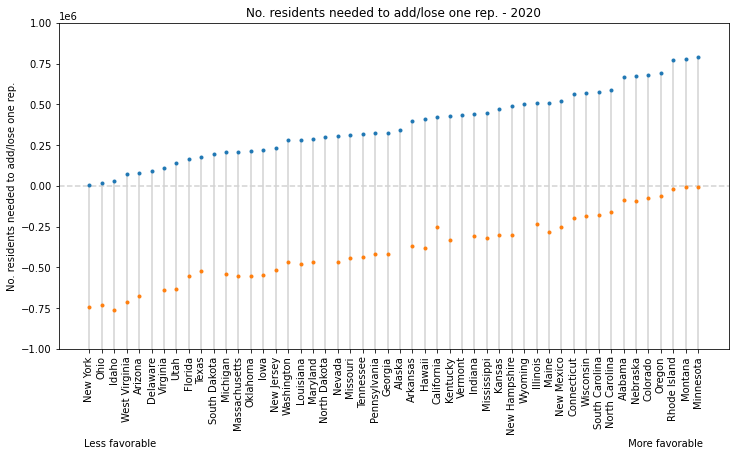

Saved figure to: figures/one_more_less_rep_2010.png


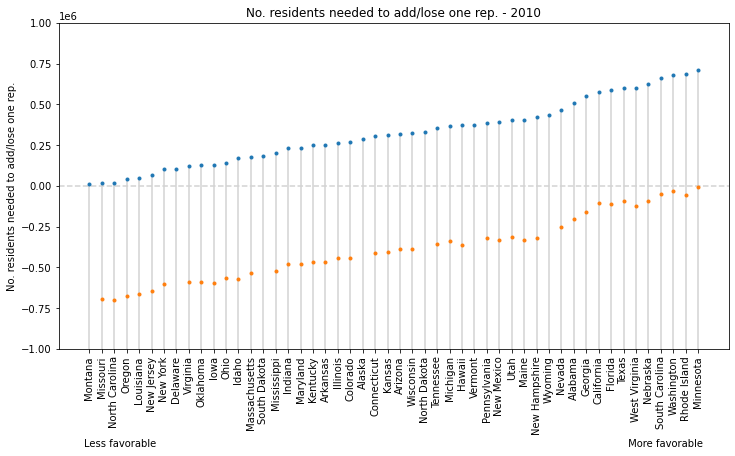

Saved figure to: figures/one_more_less_rep_2000.png


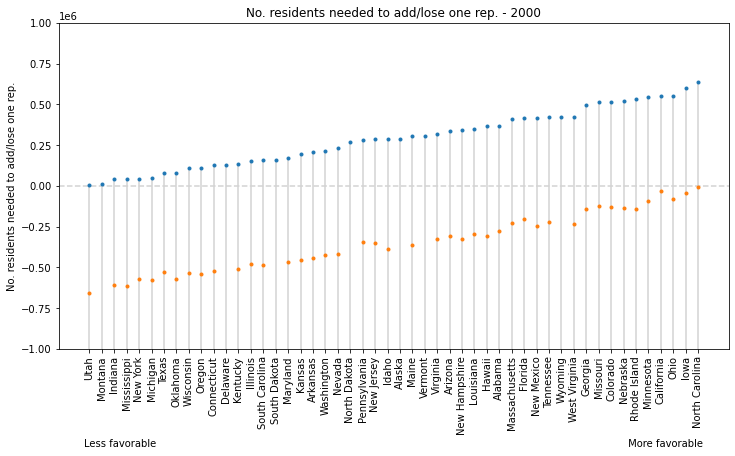

Saved figure to: figures/one_more_less_rep_1990.png


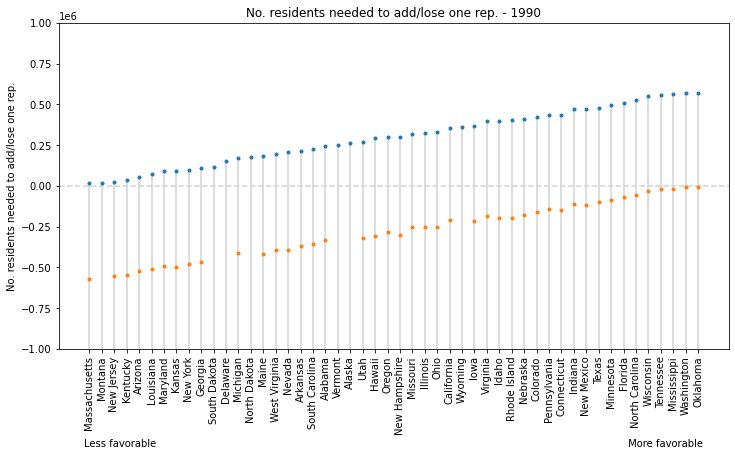

Saved figure to: figures/one_more_less_rep_1980.png


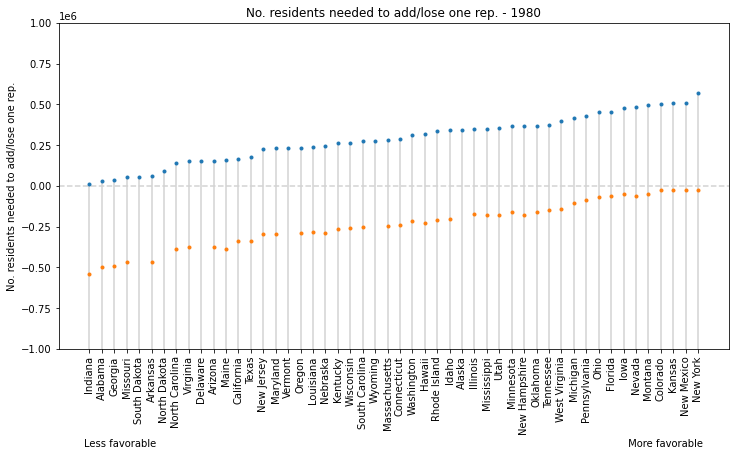

Saved figure to: figures/one_more_less_rep_1970.png


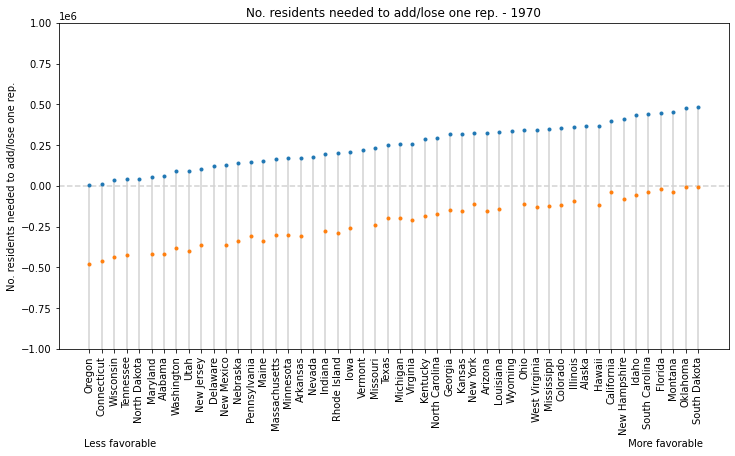

Saved figure to: figures/one_more_less_rep_1960.png


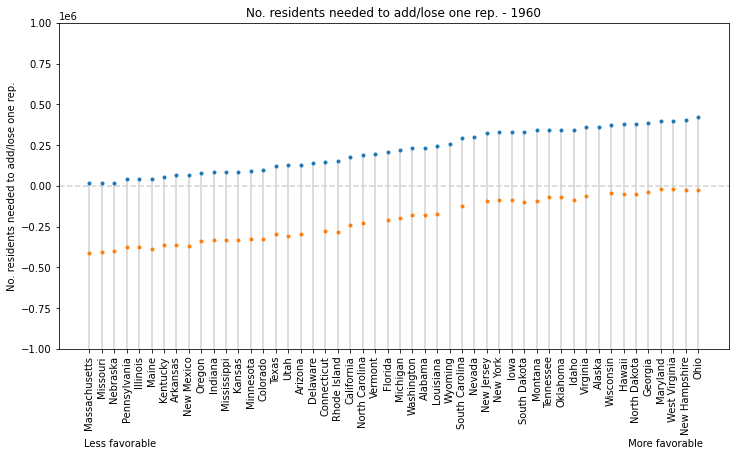

In [108]:
for year in Year:
    plt_year_sorted_by_one_more_rep(year)

## Rankings

In [167]:
def get_fair(year: Year) -> float:
    df = pd.read_csv('analyze_data/residents_per_rep.csv')
    df_year = df[df['year'] == int(year.value)]
    fair = float(df_year[df_year['state'] == 'fair']['residents per rep'])
    return fair

In [169]:
def load_fracs_one_more_rep() -> Dict[Year, Dict[St, float]]:
    fracs = {}
    for year in Year:
        df_year = pd.read_csv('analyze_data/one_more_rep_%s.csv' % year.value)

        fair = get_fair(year) / 1e6

        fracs[year] = {}
        for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
            fracs[year][st] = float(df_year[df_year['state'] == st.name]['min. population change for next rep']) / (0.5 * fair)
    return fracs

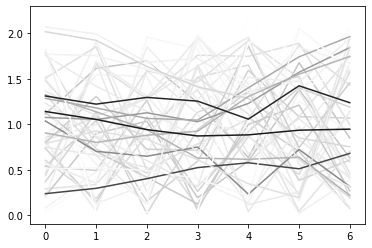

In [198]:
fracs = load_fracs_one_more_rep()

plt_data = {}
for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
    x = np.arange(0,len(fracs))
    y = [vals[st] for vals in fracs.values()]
    
    # Color by the variance in the ranking to identify states that are consistently over/under represented
    mean = np.mean(y)
    std = np.std(y)

    plt_data[st] = (x,y,mean,std)

std_max = max([x[3] for x in plt_data.values()])
std_min = min([x[3] for x in plt_data.values()])

plt.figure()
for st, dat in plt_data.items():
    x, y, mean, std = dat
    col = 0.1 + 0.9 * (1 - pow(1 - (std-std_min) / (std_max - std_min),3))
    plt.plot(x, y, color=(col,col,col))

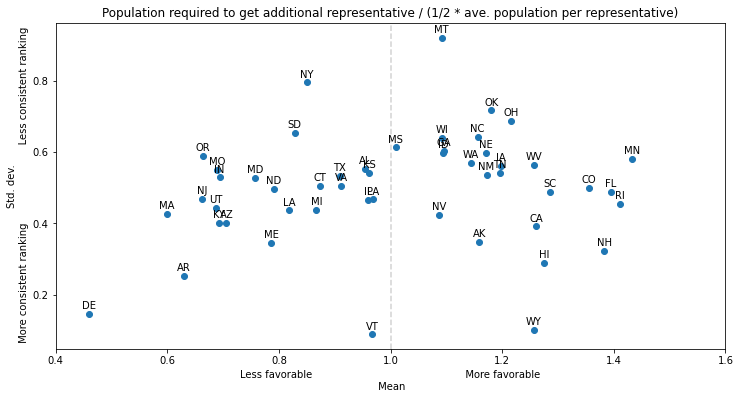

In [202]:
mean_dat = [x[2] for x in plt_data.values()]
std_dat = [x[3] for x in plt_data.values()]
labels = [x.value for x in plt_data.keys()]

plt.figure(figsize=(12,6))
plt.axvline(1,color='lightgray',linestyle='dashed')
plt.scatter(mean_dat, std_dat)
plt.xlabel('Less favorable                                                 More favorable\n Mean')
plt.ylabel('Std. dev.\n More consistent ranking                         Less consistent ranking')
plt.title('Population required to get additional representative / (1/2 * ave. population per representative)')
plt.xlim(0.4,1.6)

for i, txt in enumerate(labels):
    xytext=(0,5)
    plt.annotate(
        txt, 
        (mean_dat[i], std_dat[i]),
        textcoords="offset points", # how to position the text
        xytext=xytext, # distance from text to points (x,y)
        ha='center'
        ) # horizontal alignment can be left, right or center

## 2D ranking by additional residents and representation per state for each state in every year

In [176]:
fracs_omr = load_fracs_one_more_rep()
fracs_rpr = load_fracs_residents_per_rep()

(0.4, 1.6)

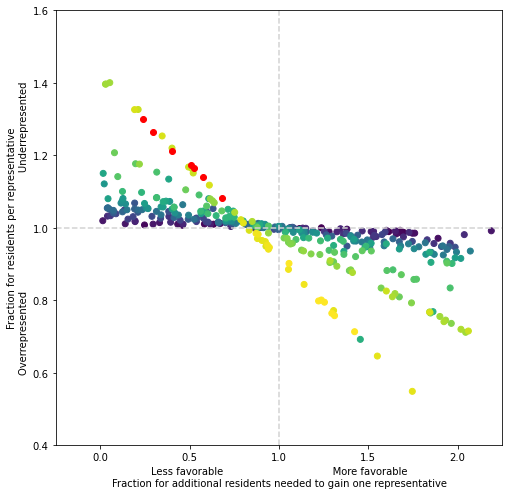

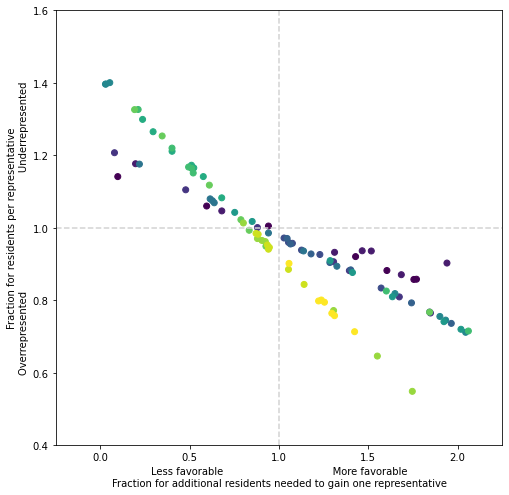

In [203]:
plt_data = {}
markers = ['s','8','p','P','*','+','x','D']
for i,st in enumerate([x for x in St if x != St.DISTRICT_OF_COLUMBIA]):
    x = []
    y = []
    cols = []
    marker = markers[i % len(markers)]
    for year in Year:
        x.append(fracs_omr[year][st])
        y.append(fracs_rpr[year][st])
        cols.append(i)

    plt_data[st] = (x,y,cols,marker)

st_highlight = St.DELAWARE
x = []
y = []
cols = []
xall = []
yall = []
colsall = []
for st, dat in plt_data.items():
    xall += dat[0]
    yall += dat[1]
    colsall += dat[2]
    if st != st_highlight:
        x += dat[0]
        y += dat[1]
        cols += dat[2]

plt.figure(figsize=(8,8))
plt.scatter(x,y,c=cols)
plt.scatter(plt_data[st_highlight][0],plt_data[st_highlight][1],color='r')

plt.axhline(1,color='lightgray',linestyle='dashed')
plt.axvline(1,color='lightgray',linestyle='dashed')
plt.xlabel('Less favorable                                   More favorable\nFraction for additional residents needed to gain one representative')
plt.ylabel('Fraction for residents per representative\nOverrepresented                                      Underrepresented')
plt.xlim(-0.25,2.25)
plt.ylim(0.4,1.6)

lim = 35
xplt = [x0 for i,x0 in enumerate(xall) if colsall[i] > lim]
yplt = [y0 for i,y0 in enumerate(yall) if colsall[i] > lim]
colsplt = [c0 for i,c0 in enumerate(colsall) if colsall[i] > lim]

plt.figure(figsize=(8,8))
plt.scatter(xplt,yplt,c=colsplt)

plt.axhline(1,color='lightgray',linestyle='dashed')
plt.axvline(1,color='lightgray',linestyle='dashed')
plt.xlabel('Less favorable                                   More favorable\nFraction for additional residents needed to gain one representative')
plt.ylabel('Fraction for residents per representative\nOverrepresented                                      Underrepresented')
plt.xlim(-0.25,2.25)
plt.ylim(0.4,1.6)

In [204]:
mean_omr = []
mean_rpr = []
ave_spread = []
labels = []
for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
    labels.append(st.value)

    y_omr = [vals[st] for vals in fracs_omr.values()]
    mean_omr.append(np.mean(y_omr))

    y_rpr = [vals[st] for vals in fracs_rpr.values()]
    mean_rpr.append(np.mean(y_rpr))

    spread_omr = max(y_omr) - min(y_omr)
    spread_rpr = max(y_rpr) - min(y_rpr)
    ave_spread.append(0.5*(spread_omr + spread_rpr))

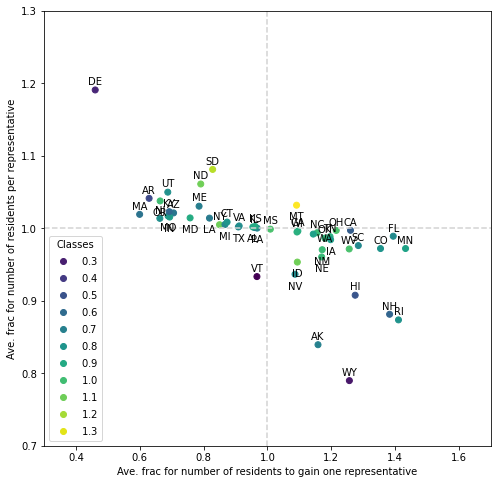

In [210]:
# plt.figure(figsize=(12,6))
fig, ax = plt.subplots(figsize=(8,8))
plt.axvline(1,color='lightgray',linestyle='dashed')
plt.axhline(1,color='lightgray',linestyle='dashed')
scatter = ax.scatter(mean_omr,mean_rpr, c=ave_spread)
plt.xlim(0.3,1.7)
plt.ylim(0.7,1.3)
plt.xlabel('Ave. frac for number of residents to gain one representative')
plt.ylabel('Ave. frac for number of residents per representative')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

rights = 'WA'
unders = ['OR','MO','IN','LA','MI','TX','MD','NM','AL','IA','NE','MT','ID','NV','PA']
for i, txt in enumerate(labels):
    if txt in unders:
        xytext=(0,-15)
    elif txt in rights:
        xytext=(12,-8)
    else:
        xytext=(0,5)
    plt.annotate(
        txt, 
        (mean_omr[i], mean_rpr[i]),
        textcoords="offset points", # how to position the text
        xytext=xytext, # distance from text to points (x,y)
        ha='center'
        ) # horizontal alignment can be left, right or center

### Why does Delaware do so poorly? Population change? Population ranking?

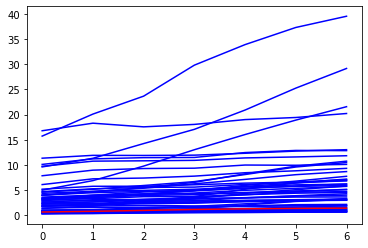

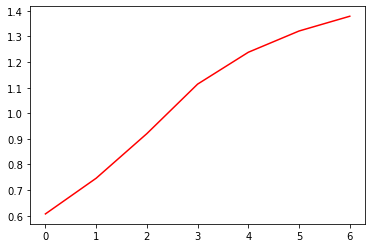

In [171]:
st_color = St.NEW_HAMPSHIRE

states = load_states(list(St))
for st,state in states.items():
    if st == st_color:
        continue
    pop = [x.apportionment for x in state.pop_true.values()]

    plt.plot(pop,color='b')

pop = [x.apportionment for x in states[st_color].pop_true.values()]
plt.plot(pop,color='r')

plt.figure()
plt.plot(pop,color='r')

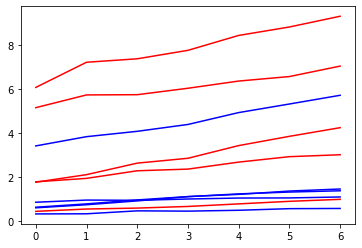

In [180]:
st_best = [St.WYOMING,St.NEW_HAMPSHIRE,St.RHODE_ISLAND,St.MINNESOTA,St.HAWAII]
st_worst = [St.DELAWARE,St.ARKANSAS,St.MASSACHUSETTS,St.OREGON,St.NEW_JERSEY]
for st in st_best + st_worst:
    pop = [x.apportionment for x in states[st].pop_true.values()]

    if st in st_worst:
        plt.plot(pop,color='r')
    else:
        plt.plot(pop,color='b')    

### Rank populations

In [42]:
states = load_states(list(St))
rankings = {}
for year in Year:
    rankings[year] = []
    for st,state in states.items():
        pop = state.pop_true[year].apportionment
        rankings[year].append((pop,st))

    rankings[year].sort(key = lambda x: -x[0])

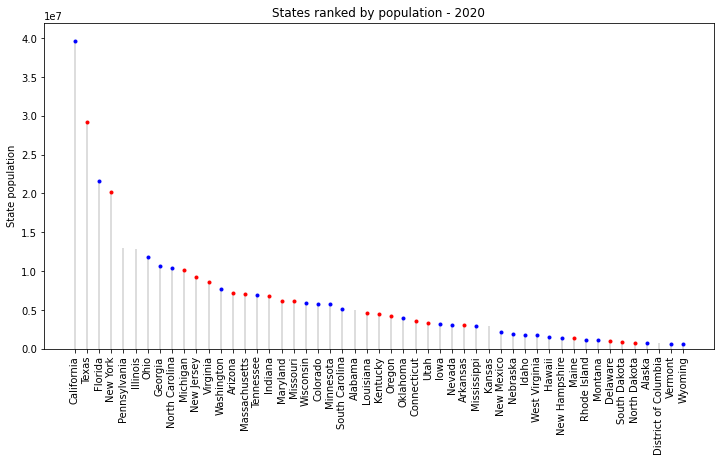

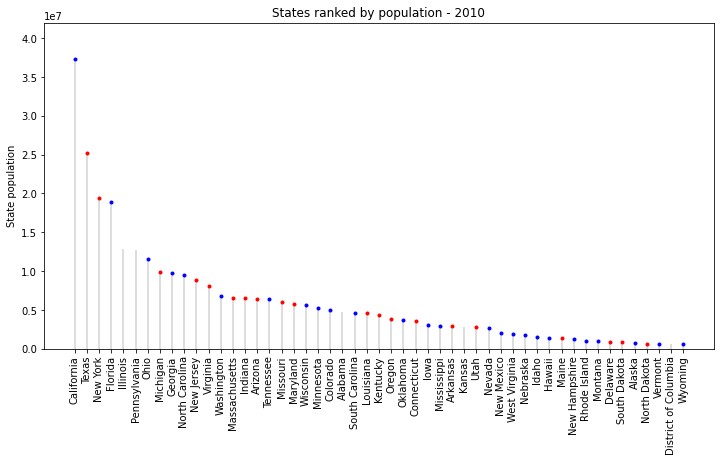

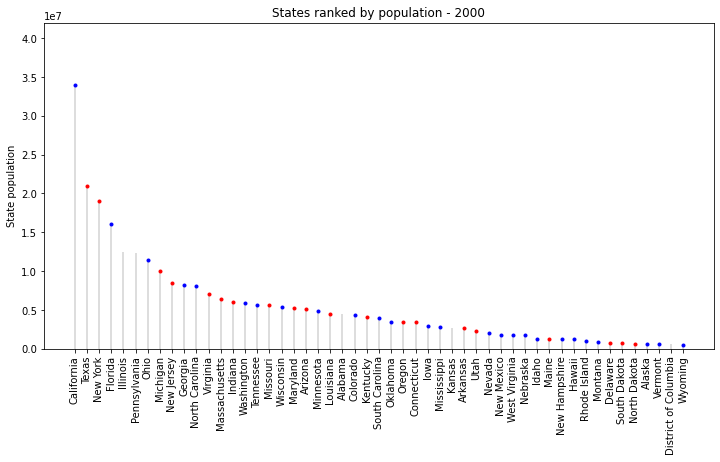

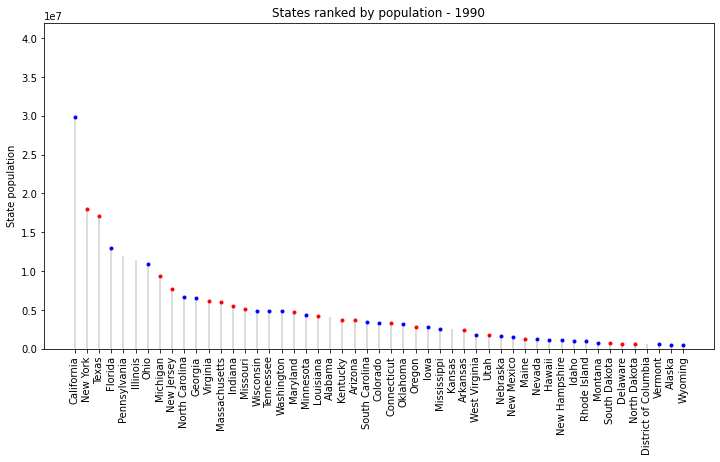

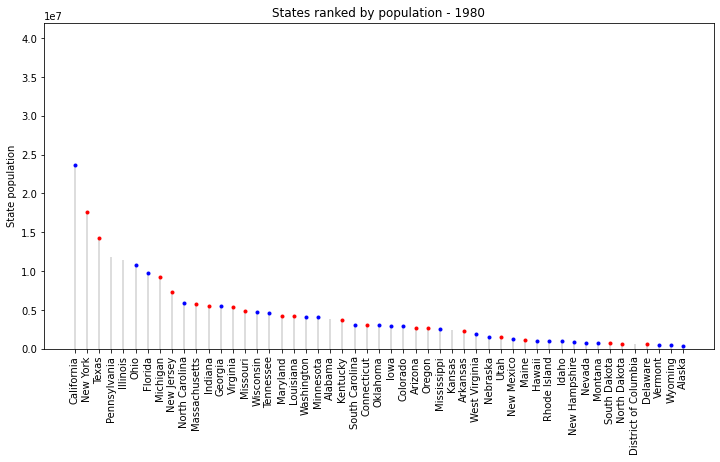

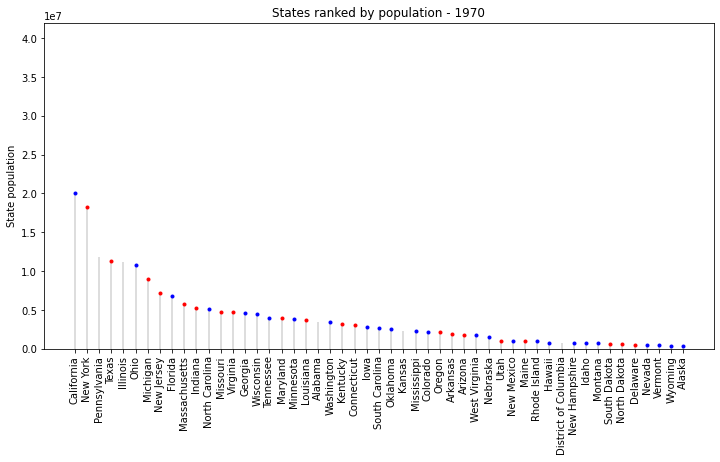

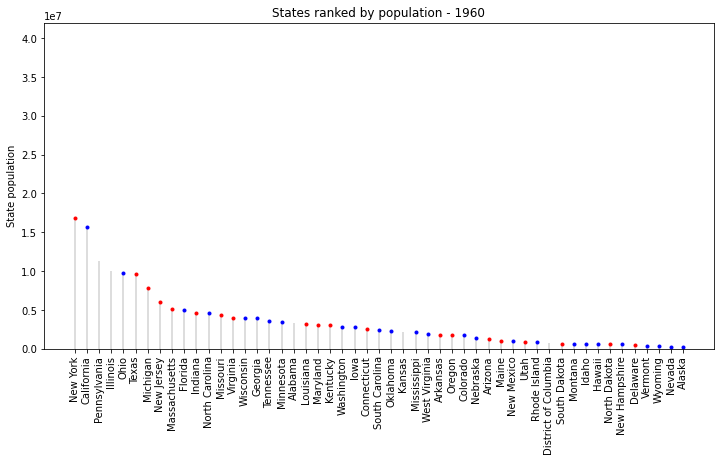

In [59]:
# st_best = [St.WYOMING,St.NEW_HAMPSHIRE,St.RHODE_ISLAND,St.MINNESOTA,St.HAWAII,St.ALASKA,St.COLORADO,St.FLORIDA,St.WEST_VIRGINIA,St.NEW_MEXICO]
# st_worst = [St.DELAWARE,St.ARKANSAS,St.MASSACHUSETTS,St.OREGON,St.NEW_JERSEY,St.SOUTH_DAKOTA,St.KENTUCKY,St.UTAH,St.NORTH_DAKOTA,St.MARYLAND]

st_best = []
st_worst = []
for st in St:
    if st.value in labels:
        i = labels.index(st.value)
        if mean_omr[i] < 25 and mean_rpr[i] < 25:
            st_best.append(st)
        elif mean_omr[i] > 25 and mean_rpr[i] > 25:
            st_worst.append(st)

st_best_name = [s.name for s in st_best]
st_worst_name = [s.name for s in st_worst]

for year in Year:
    xticks = [p[1].name for p in rankings[year]]
    x = np.arange(0,len(xticks))
    y = [1e6*p[0] for p in rankings[year]]
    
    xb = [x0 for i,x0 in enumerate(x) if xticks[i] in st_best_name]
    yb = [y0 for i,y0 in enumerate(y) if xticks[i] in st_best_name]
    xr = [x0 for i,x0 in enumerate(x) if xticks[i] in st_worst_name]
    yr = [y0 for i,y0 in enumerate(y) if xticks[i] in st_worst_name]

    plt.figure(figsize=(12,6))
    plt.xticks(x, xticks, rotation=90)
    plt.plot(xb,yb,'.',color='b')
    plt.plot(xr,yr,'.',color='r')
    plt.ylim(0,42e6)
    plt.vlines(x, [0], y, color='lightgray')
    plt.title("States ranked by population - %s" % year.value)
    plt.ylabel("State population")

### Fit Pareto dist

In [227]:
from scipy.stats import expon
import scipy.stats as stats

In [228]:
data = [state.pop_true[Year.YR2020].apportionment for state in states.values()]
loc_expon, scale_expon = stats.expon.fit(data, loc=0, scale=1)

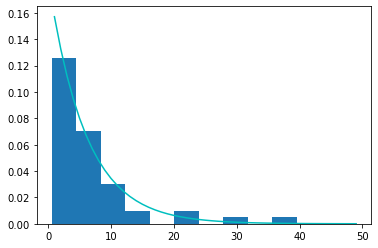

In [229]:
fig, ax = plt.subplots(1, 1)
plt.hist(data, density=True)

x = np.arange(1,50)
ax.plot(x, expon.pdf(x, loc_expon, scale_expon), 'c-')

[1.985944367553841, 20.93303203505043, 12.197583379237445, 2.0353835189337808, 11.382904723448057, 4.074533982611812, 7.576802758919504, 13.318672285768663, 1.6252948262567988, 18.76747809026025, 11.284599965799922, 0.8826513032617124, 6.589975041233933, 10.060896492586716, 2.6225790659553776, 2.722346417271133, 2.9612100857356265, 5.0664190111834735, 8.933869490506435, 4.963473877462219, 3.299319669128359, 2.0933805586423606, 3.2735421842595063, 10.054404715629634, 3.1585670664736165, 10.743549778987981, 18.159062210305624, 3.954028058015523, 2.023528560605895, 14.738820688063429, 8.589485618223575, 1.9539180844821122, 6.589951155559744, 2.367236275921874, 15.292102289580619, 4.780662576389824, 11.223596954356228, 5.536248387653957, 5.3297025289819375, 1.0532720794426973, 20.70400195957722, 9.28720188802951, 6.6602158906606865, 3.9293853522474387, 11.411117548560139, 2.6942993143363547, 12.38586607151311, 11.197089287851522, 1.076583048421337, 3.2781247451320787]


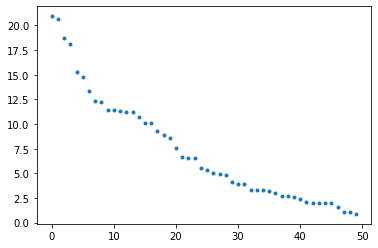

In [230]:
# Sample populations
samples = list(expon.rvs(loc_expon, scale_expon, size=50))
print(samples)
samples.sort(key = lambda x: -x)

plt.figure()
plt.plot(samples,'.')

## 2D rankings by raw values

Saved figure to: figures/favorable2d_2020.png


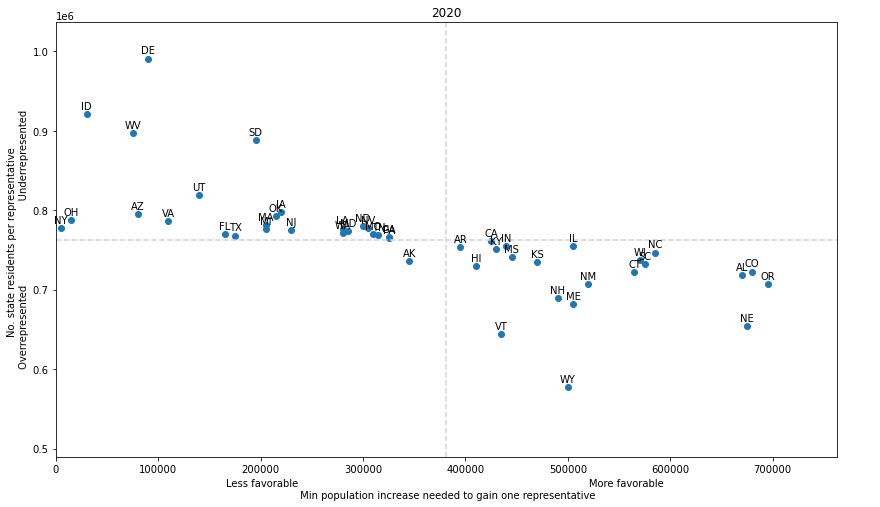

Saved figure to: figures/favorable2d_2010.png


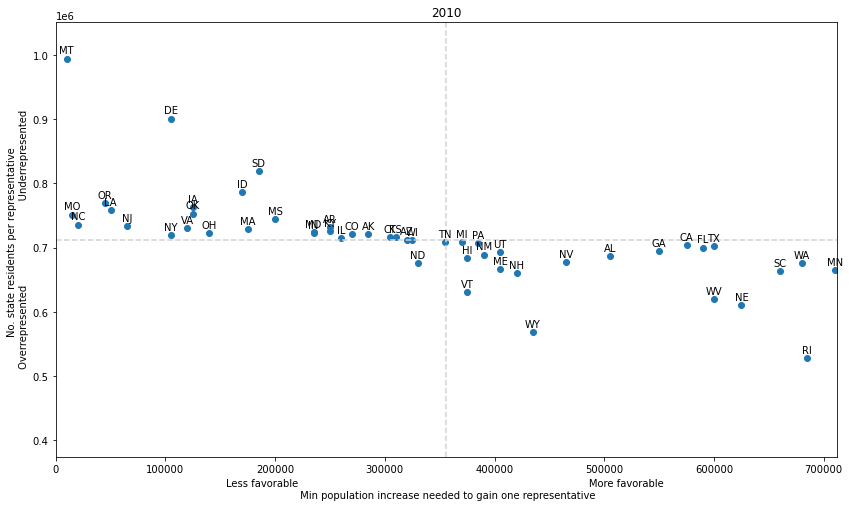

Saved figure to: figures/favorable2d_2000.png


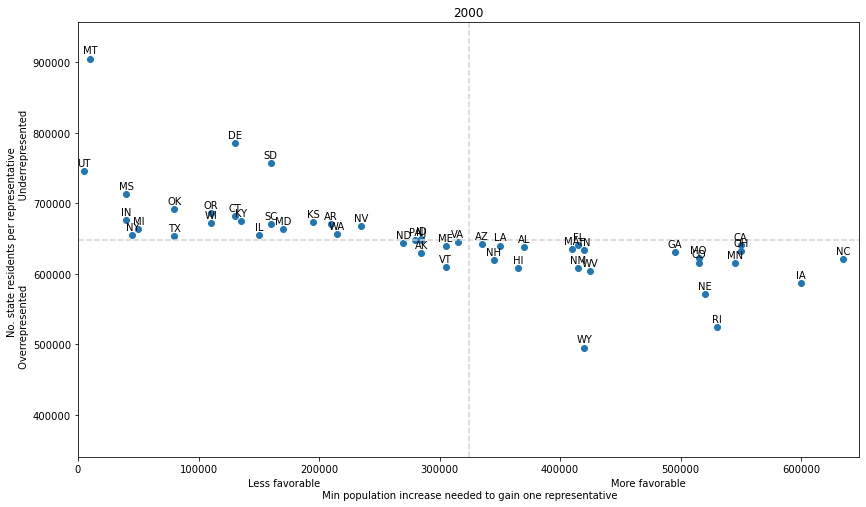

Saved figure to: figures/favorable2d_1990.png


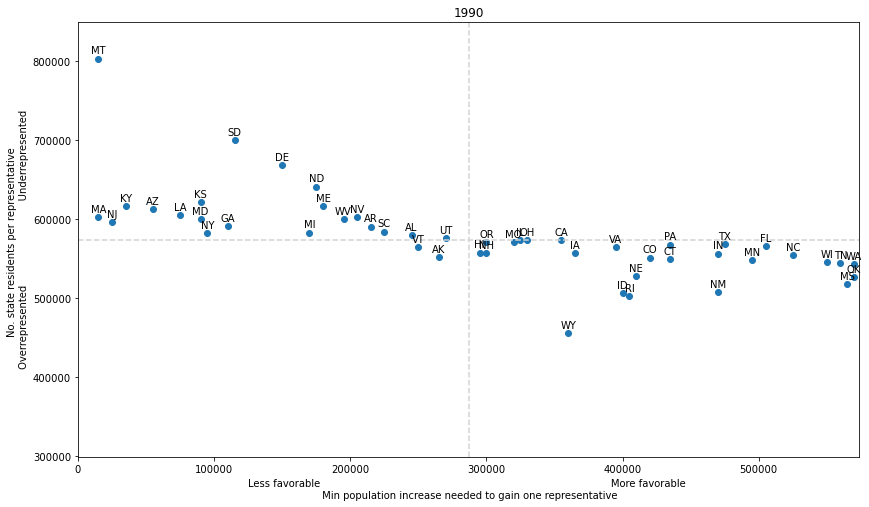

Saved figure to: figures/favorable2d_1980.png


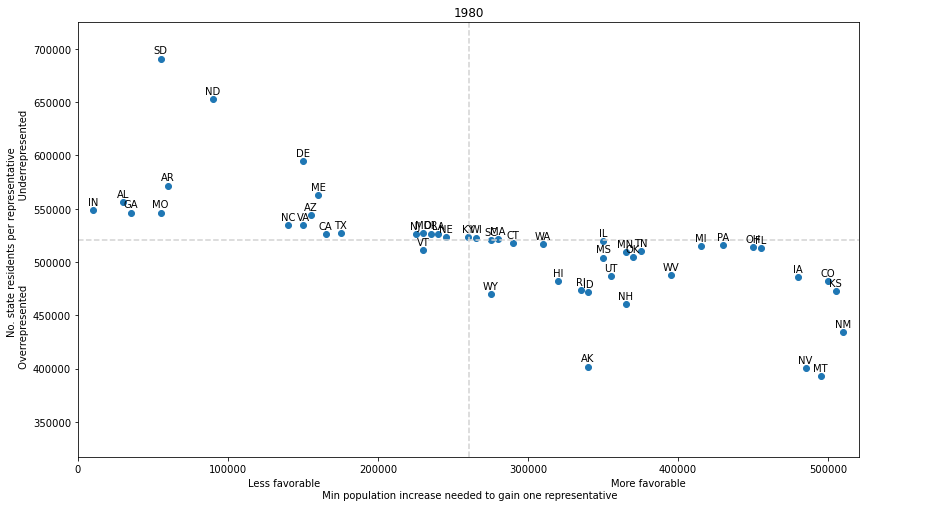

Saved figure to: figures/favorable2d_1970.png


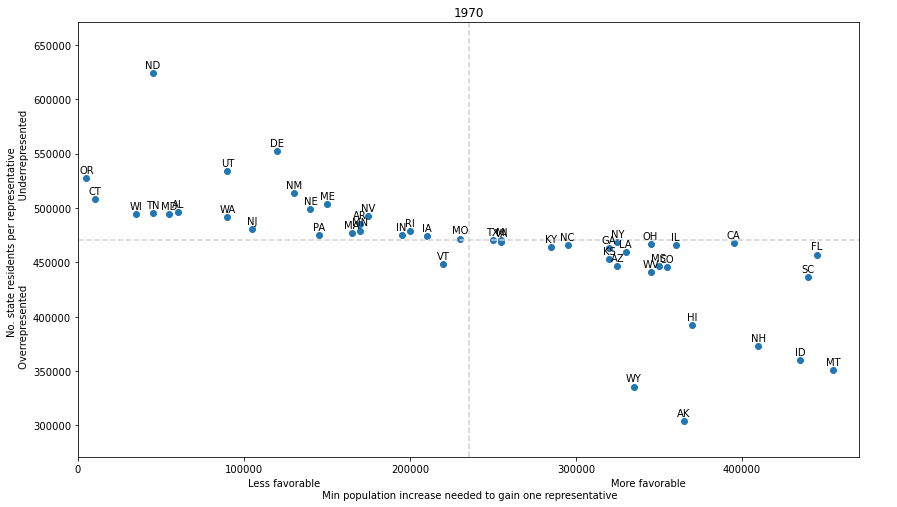

Saved figure to: figures/favorable2d_1960.png


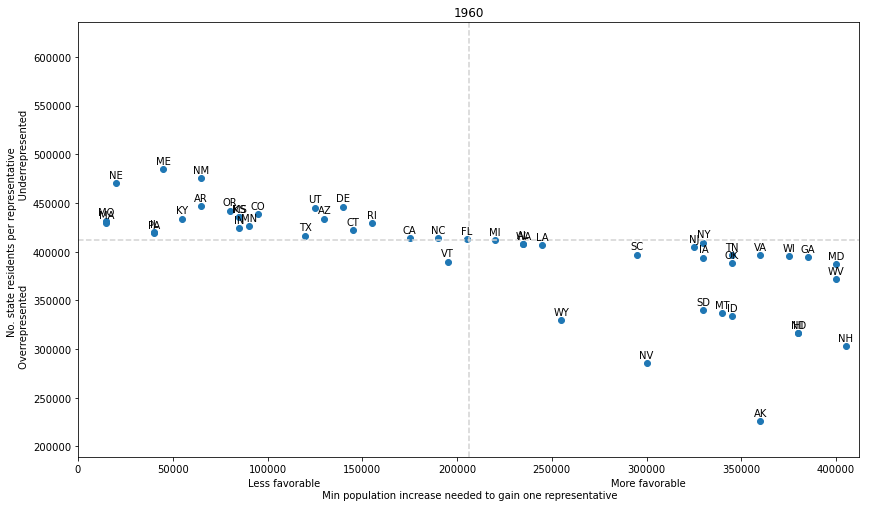

In [64]:
# Import
for year in Year:
    df_more = pd.read_csv('analyze_data/one_more_rep_%s.csv' % year.value)
    df_res = pd.read_csv('analyze_data/residents_per_rep.csv')
    df_res = df_res[df_res['year'] == int(year.value)]

    # Plotting data
    plt_data = {}
    for idx, row in df_more.iterrows():
        state = row['state']
        st = St.fromName(state)
        dpop = 1e6*row['min. population change for next rep']
        cpr = float(df_res[df_res['state'] == st.name]['residents per rep'])
        plt_data[st] = [dpop, cpr]

    fair = float(df_res[df_res['state'] == 'fair']['residents per rep'])

    # Scatter plot
    x = [p[0] for p in plt_data.values()]
    y = [p[1] for p in plt_data.values()]
    labels = [x.value for x in list(plt_data.keys())]

    min_delta = fair - min(y)
    max_delta = max(y) - fair
    delta = 1.2*max(min_delta, max_delta)

    plt.figure(figsize=(14,8))
    plt.scatter(x,y)
    plt.ylabel("No. state residents per representative \n Overrepresented                           Underrepresented")

    plt.axhline(fair,color='lightgray',linestyle='dashed')
    plt.ylim(fair-delta,fair+delta)
    plt.xlim(0,fair)
    plt.axvline(0.5*fair,color='lightgray',linestyle='dashed')
    plt.xlabel("Less favorable                                                                                             More favorable \n Min population increase needed to gain one representative")
    plt.title('%s' % year.value)

    for i, txt in enumerate(labels):
        plt.annotate(
            txt, 
            (x[i], y[i]),
            textcoords="offset points", # how to position the text
            xytext=(0,5), # distance from text to points (x,y)
            ha='center'
            ) # horizontal alignment can be left, right or center

    save_fig('favorable2d_%s.png' % year.value)
    plt.show()